This notebook contains differential expression and GO-term & pathway enrichment analysis of the Neuronal differention patient dataset.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import batchglm
import diffxpy.api as de
import patsy as pat
import logging, warnings
from batchglm.pkg_constants import TF_CONFIG_PROTO

/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
de.__version__

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.3+116.g0075c62 anndata==0.6.22.post2.dev80+g72c2bde umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.24.1 scikit-learn==0.21.3 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


'v0.6.1'

In [3]:
#Set number of threads
TF_CONFIG_PROTO.inter_op_parallelism_threads = 1
TF_CONFIG_PROTO.intra_op_parallelism_threads = 12


In [26]:
#User inputs
folder = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/'

adata_mnn_final = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_patients_full_mnn_final.h5ad'

de_output_pickle = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_patients_de_results_louvain_final_diffxpy_sf.pkl'

de_output_pickle_bulk = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_patients_de_results_louvain_final_diffxpy_sf_bulk_like.pkl'

de_output_pickle_coarse = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_patients_de_results_louvain_final_coarse_diffxpy_sf.pkl'

de_output_base = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_patients_sf_de_results_louvain_final'

enrich_output_base = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_patients_sf_enrich_results_louvain_final'

# Read the data

In [5]:
adata = sc.read(adata_mnn_final)

In [6]:
adata

AnnData object with n_obs × n_vars = 30557 × 24920 
    obs: 'Demux_state', 'Donor', 'Lane', 'donor', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'louvain_final_nohvg', 'louvain_prefinal_nohvg', 'condition', 'age', 'years_of_illness', 'gender', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_final', 'Ferroptosis_pos_raw', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_raw', 'Ferroptosis_neg_corr', 'Apoptosis_pos_raw', 'Apoptosis_pos_corr', 'Apoptosis_neg_raw', 'Apoptosis_neg_corr', 'Necroptosis_pos_raw', 'Necroptosis_pos_corr', 'Autophagy_pos_raw', 'Autophagy_pos_corr', 'Pathanatos_pos_raw', 'Pathanatos_pos_corr'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'condition_colors', 'donor_colors', 'gender_colors', 'louvain', 'louvain_final_colors', 'louvain_final_nohvg_co

# Check the data

In [7]:
np.mean(adata.layers['counts'].astype(int) != adata.layers['counts'])

0.0

Counts are actually all integer counts.

In [8]:
adata.obs.condition.value_counts()

Parkinson    18887
Control      11670
Name: condition, dtype: int64

In [9]:
adata.obs.groupby(['louvain_final'])['condition'].value_counts()

louvain_final              condition
Glial prec. (myelinating)  Parkinson     824
                           Control       149
NCSC                       Control      2758
                           Parkinson    2254
Apop. NCSC                 Control       107
                           Parkinson      98
NSC2                       Parkinson    3872
                           Control      2042
NSC2 (G2M)                 Parkinson    1496
                           Control       427
NSC1                       Parkinson    4076
                           Control      3554
NSC1 (G2M)                 Parkinson    4874
                           Control      2106
immature neurons           Parkinson     423
                           Control       109
Apop. NSC                  Parkinson     970
                           Control       418
Name: condition, dtype: int64

Note:
- General imbalance between Parkinson and control cell numbers
- imbalance strongly represented in 'NSC (Shh)', 'NSC (Shh, G2M)', 'Glial precursors (myelinating)', and 'immature neurons' clusters
- more control cells than expected in 'NCSC (low MT)' and 'NSC (early)'

In [10]:
adata.obs['louvain_final_coarse'] = ['NSC1' if ct.startswith('NSC1') else 'NSC2' if ct.startswith('NSC2') else ct for ct in adata.obs.louvain_final]

... storing 'louvain_final_coarse' as categorical


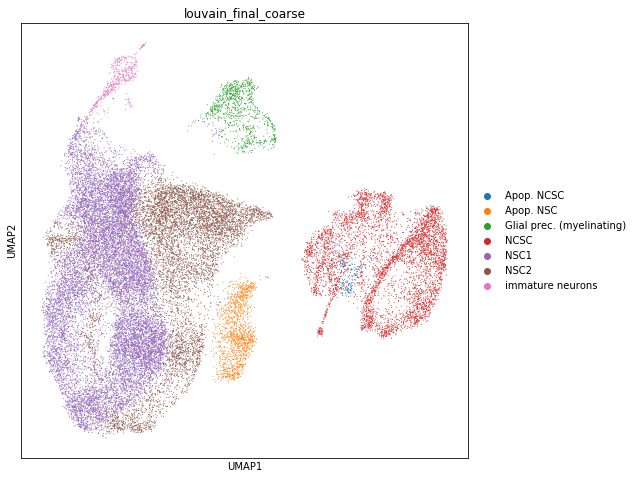

In [11]:
sc.pl.umap(adata, color='louvain_final_coarse')

# DE Testing

Calculate DE genes per cluster.

In [14]:
de_results = dict()
de_results_coarse = dict()

In [13]:
de.utils.preview_coef_names(
    sample_description=adata.obs,
    formula="~1+condition+Donor", 
)

array(['Intercept', 'condition[T.Parkinson]', 'Donor[T.UKERi1JF-R1-018]',
       'Donor[T.UKERiM89-R1-005]', 'Donor[T.UKERiC99-R1-007]',
       'Donor[T.UKERiR66-R1-007]', 'Donor[T.UKERiG3G-R1-039]',
       'Donor[T.UKERi1E4-R1-003]', 'Donor[T.UKERiAY6-R1-003]',
       'Donor[T.UKERiPX7-R1-001]', 'Donor[T.UKERi88H-R1-002]',
       'Donor[T.UKERiO3H-R1-005]', 'Donor[T.UKERi82A-R1-002]'],
      dtype='<U24')

In [15]:
# Test the new "coarse" clusters quickly
for clust in ['NSC1', 'NSC2']:
    adata_tmp = adata[adata.obs['louvain_final_coarse'] == clust,:].copy()

    print(f'In cluster {clust}:')
    print(adata_tmp.obs.condition.value_counts())

    # Filter out genes to reduce multiple testing burden
    sc.pp.filter_genes(adata_tmp, min_cells=50)
    print(f'Testing {adata_tmp.n_vars} genes...')
    print("")
    
    test_tmp = de.test.wald(
    data=adata_tmp.layers['counts'],
    formula_loc="~ 1 + condition + Donor + size_factors",
    as_numeric=['size_factors'],
    coef_to_test=["condition[T.Parkinson]"],
    sample_description=adata_tmp.obs,
    gene_names=adata_tmp.var_names,
    constraints_loc={'Donor':'condition'},
    noise_model='nb',
    dtype="float64"
    )
    
    #Store the results
    de_results_coarse[clust] = test_tmp

In cluster NSC1:
Parkinson    8950
Control      5660
Name: condition, dtype: int64
filtered out 995 genes that are detectedin less than 50 cells
Testing 23925 genes...



Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:diffxpy:Fitting model...
In cluster NSC2:
Parkinson    5368
Control      2469
Name: condition, dtype: int64
filtered out 1247 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


Testing 23673 genes...

INFO:diffxpy:Fitting model...


In [16]:
for clust in adata.obs['louvain_final'].cat.categories:
    adata_tmp = adata[adata.obs['louvain_final'] == clust,:].copy()

    print(f'In cluster {clust}:')
    print(adata_tmp.obs.condition.value_counts())

    # Filter out genes to reduce multiple testing burden
    sc.pp.filter_genes(adata_tmp, min_cells=50)
    print(f'Testing {adata_tmp.n_vars} genes...')
    print("")
    
    test_tmp = de.test.wald(
    data=adata_tmp.layers['counts'],
    formula_loc="~ 1 + condition + Donor + size_factors",
    as_numeric=['size_factors'],
    coef_to_test=["condition[T.Parkinson]"],
    sample_description=adata_tmp.obs,
    gene_names=adata_tmp.var_names,
    constraints_loc={'Donor':'condition'},
    noise_model='nb',
    dtype="float64"
    )
    
    #Store the results
    de_results[clust] = test_tmp
    

In cluster Glial prec. (myelinating):
Parkinson    824
Control      149
Name: condition, dtype: int64
filtered out 3489 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


Testing 21431 genes...


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:diffxpy:Fitting model...
In cluster NCSC:
Control      2758
Parkinson    2254
Name: condition, dtype: int64
filtered out 1850 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


Testing 23070 genes...

INFO:diffxpy:Fitting model...
In cluster Apop. NCSC:
Control      107
Parkinson     98
Name: condition, dtype: int64
filtered out 6333 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


Testing 18587 genes...

INFO:diffxpy:Fitting model...
In cluster NSC2:
Parkinson    3872
Control      2042
Name: condition, dtype: int64
filtered out 1397 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


Testing 23523 genes...

INFO:diffxpy:Fitting model...
In cluster NSC2 (G2M):
Parkinson    1496
Control       427
Name: condition, dtype: int64
filtered out 1665 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


Testing 23255 genes...

INFO:diffxpy:Fitting model...
In cluster NSC1:
Parkinson    4076
Control      3554
Name: condition, dtype: int64
filtered out 1351 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


Testing 23569 genes...

INFO:diffxpy:Fitting model...
In cluster NSC1 (G2M):
Parkinson    4874
Control      2106
Name: condition, dtype: int64
filtered out 1268 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


Testing 23652 genes...

INFO:diffxpy:Fitting model...
In cluster immature neurons:
Parkinson    423
Control      109
Name: condition, dtype: int64
filtered out 3736 genes that are detectedin less than 50 cells
Testing 21184 genes...



Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


INFO:diffxpy:Fitting model...
In cluster Apop. NSC:
Parkinson    970
Control      418
Name: condition, dtype: int64
filtered out 2992 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


Testing 21928 genes...

INFO:diffxpy:Fitting model...


### Bulk-like DE testing across all clusters

In [17]:
# Make a copy for the testing
adata_test = adata.copy()

print(adata_test.obs.condition.value_counts())

# Filter out genes to reduce multiple testing burden
#sc.pp.filter_genes(adata_test, min_cells=50)
print(f'Testing {adata_test.n_vars} genes...')
print("")
    
test_bulk = de.test.wald(
    data=adata_test.layers['counts'],
    formula_loc="~ 1 + condition + Donor + size_factors",
    as_numeric=['size_factors'],
    coef_to_test=["condition[T.Parkinson]"],
    sample_description=adata_test.obs,
    gene_names=adata_test.var_names,
    constraints_loc={'Donor':'condition'},
    noise_model='nb',
    dtype="float64"
)


Built constraints: Donor[UKERi1JF-R1-018]+Donor[UKERiG3G-R1-039]+Donor[UKERi1E4-R1-003]+Donor[UKERiO3H-R1-005]+Donor[UKERi82A-R1-002]=0, Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiC99-R1-007]+Donor[UKERiR66-R1-007]+Donor[UKERiAY6-R1-003]+Donor[UKERiPX7-R1-001]+Donor[UKERi88H-R1-002]=0


Parkinson    18887
Control      11670
Name: condition, dtype: int64
Testing 24920 genes...

INFO:diffxpy:Fitting model...


# Check some data

In [18]:
de_results['NCSC'].summary().sort_values(by='qval', ascending=True).iloc[:10,:]

gene      pval     qval    log2fc      mean  zero_mean      grad  \
4  AL732372.2  0.000000  0.00000  2.702937  0.018156      False  0.000016   
6    MTND1P23  0.000000  0.00000  1.492391  0.069034      False  0.000028   
8    MTCO1P12  0.101271  0.48724  0.208735  0.334597      False  0.002111   
0      CICP27  0.992756  1.00000 -0.044657  0.002394      False  0.006267   
1  AL627309.6  0.971201  1.00000 -0.153275  0.003192      False  0.007655   
2  AL627309.5  0.828113  1.00000  0.845765  0.003990      False  0.000164   
3  AP006222.1  0.772939  1.00000  1.986103  0.012969      False  0.000091   
5  AL669831.3  0.896800  1.00000  1.093490  0.004988      False  0.000336   
7    MTND2P28  0.487773  1.00000  0.454651  0.138268      False  0.001523   
9    MTCO2P12  0.399812  1.00000  0.131396  0.274142      False  0.002992   

   coef_mle   coef_sd           ll  
4  2.702937  0.150081  -437.420995  
6  1.492391  0.115044 -1260.808010  
8  0.208735  0.127377 -3664.594442  
0 -0.044657  4.918824  -538.700108  
1 -0.153275  4.245670  -724.781784  
2  0.845765  3.895330  -118.164023  
3  1.986103  6.883445  -328.947228  
5  1.093490  8.430639  -136.051544  
7  0.454651  0.655253 -2049.852275  
9  0.131396  0.156060 -3211.950176

In [19]:
# Test if model did not converger for some genes and some clusters
np.sum(de_results['NCSC'].summary()['ll'] == np.float64('-inf'))
np.sum(de_results['NSC2 (G2M)'].summary()['ll'] == np.float64('-inf'))

0

0

In [20]:
test_bulk.summary().sort_values(by='qval', ascending=True).iloc[:10,:]

gene      pval      qval    log2fc      mean  zero_mean      grad  \
9    MTND2P28  0.000387  0.001072 -0.122503  0.092614      False  0.000931   
8    MTND1P23  0.000815  0.002154 -0.169664  0.038911      False  0.000103   
5  AP006222.1  0.000884  0.002324 -0.259966  0.016886      False  0.000030   
3  AL627309.5  0.018648  0.038626 -0.424163  0.003371      False  0.000010   
4  FO538757.1  0.572179  0.694324 -0.091099  0.003174      False  0.003445   
7  AL669831.3  0.607318  0.724151  0.072144  0.010636      False  0.000081   
2  AL627309.6  0.708894  0.805011 -0.072037  0.005727      False  0.000009   
6  AL732372.2  0.729813  0.820840  0.025729  0.018948      False  0.000066   
1      CICP27  0.783328  0.860542 -0.064272  0.001800      False  0.001054   
0  AL627309.1  0.910507  0.945738  0.534482  0.001244      False  0.000013   

   coef_mle   coef_sd           ll  
9 -0.122503  0.034519 -9370.700952  
8 -0.169664  0.050680 -4959.131314  
5 -0.259966  0.078186 -2506.567742  
3 -0.424163  0.180304  -669.616030  
4 -0.091099  0.161282 -4412.441302  
7  0.072144  0.140383 -1717.544549  
2 -0.072037  0.192951 -1039.975207  
6  0.025729  0.074496 -2798.034333  
1 -0.064272  0.233729 -2478.353316  
0  0.534482  4.755217  -279.023488

# Post-process data

In [16]:
de_signif_coarse = dict()
de_full_res_coarse = dict()

for clust in de_results_coarse:
    tmp = de_results_coarse[clust].summary()

    n_infll = np.sum(tmp['ll'] == np.float64('-inf'))
    print(f'There are {n_infll} -inf log likelihood values. Filtering these out now...')
    tmp = tmp.loc[tmp['ll'] != np.float64('-inf')]

    #Sort values by q-value
    tmp.sort_values(by='qval', ascending=True, inplace=True)
    
    de_full_res_coarse[clust] = tmp.copy()
    
    #Filter by q-value to get significant DE genes
    tmp_filt = tmp.loc[tmp['qval'] < 0.05]
    de_signif_coarse[clust] = tmp_filt.copy()

There are 0 -inf log likelihood values. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...


In [21]:
de_signif = dict()
de_full_res = dict()

for clust in de_results:
    tmp = de_results[clust].summary()

    n_infll = np.sum(tmp['ll'] == np.float64('-inf'))
    print(f'There are {n_infll} -inf log likelihood values. Filtering these out now...')
    tmp = tmp.loc[tmp['ll'] != np.float64('-inf')]

    #Sort values by q-value
    tmp.sort_values(by='qval', ascending=True, inplace=True)
    
    de_full_res[clust] = tmp.copy()
    
    #Filter by q-value to get significant DE genes
    tmp_filt = tmp.loc[tmp['qval'] < 0.05]
    de_signif[clust] = tmp_filt.copy()

There are 0 -inf log likelihood values. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...


In [22]:
# bulk-like data
bulk_res = test_bulk.summary()

n_infll = np.sum(bulk_res['ll'] == np.float64('-inf'))
print(f'There are {n_infll} -inf log likelihood values. Filtering these out now...')
bulk_res = bulk_res.loc[bulk_res['ll'] != np.float64('-inf')]

#Sort values by q-value
bulk_res.sort_values(by='qval', ascending=True, inplace=True)
        
#Filter by q-value to get significant DE genes
bulk_res_filt = bulk_res.loc[bulk_res['qval'] < 0.05]


There are 0 -inf log likelihood values. Filtering these out now...


# DEG analysis

In [17]:
# Number of differentially expressed genes (DEGs)
print('DEGs at FDR < 0.05:')
{clust:de_signif_coarse[clust].shape[0] for clust in de_signif_coarse}

print('DEGs at FDR < 0.01:')
{clust:de_signif_coarse[clust].loc[(de_signif_coarse[clust]['qval']<0.01)].shape[0] for clust in de_signif_coarse}

DEGs at FDR < 0.05:


{'NSC1': 8304, 'NSC2': 6720}

DEGs at FDR < 0.01:


{'NSC1': 6592, 'NSC2': 5124}

In [23]:
# Number of differentially expressed genes (DEGs)
print('DEGs at FDR < 0.05:')
{clust:de_signif[clust].shape[0] for clust in de_signif}

print('DEGs at FDR < 0.01:')
{clust:de_signif[clust].loc[(de_signif[clust]['qval']<0.01)].shape[0] for clust in de_signif}

DEGs at FDR < 0.05:


{'Glial prec. (myelinating)': 2135,
 'NCSC': 2643,
 'Apop. NCSC': 571,
 'NSC2': 5351,
 'NSC2 (G2M)': 3089,
 'NSC1': 4517,
 'NSC1 (G2M)': 7094,
 'immature neurons': 603,
 'Apop. NSC': 706}

DEGs at FDR < 0.01:


{'Glial prec. (myelinating)': 1744,
 'NCSC': 2153,
 'Apop. NCSC': 497,
 'NSC2': 3812,
 'NSC2 (G2M)': 2055,
 'NSC1': 3320,
 'NSC1 (G2M)': 5522,
 'immature neurons': 488,
 'Apop. NSC': 577}

In [24]:
#DEGs in bulk-like data
print('DEGs at FDR < 0.05:')
print(f'Bulk: {bulk_res_filt.shape[0]}')

print('DEGs at FDR < 0.01:')
degnum001 = bulk_res_filt.loc[(bulk_res_filt['qval']<0.01)].shape[0]
print(f'Bulk: {degnum001}')

DEGs at FDR < 0.05:
Bulk: 12397
DEGs at FDR < 0.01:
Bulk: 10585


Notes:
- there are quite a lot of DEGs at FDR < 0.05 and at FDR < 0.01
- Could use either threshold, FDR < 0.01 would be okay for higher confidence

Cluster NSC1:


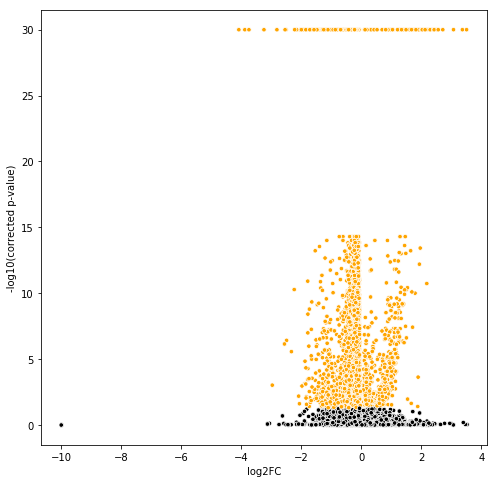

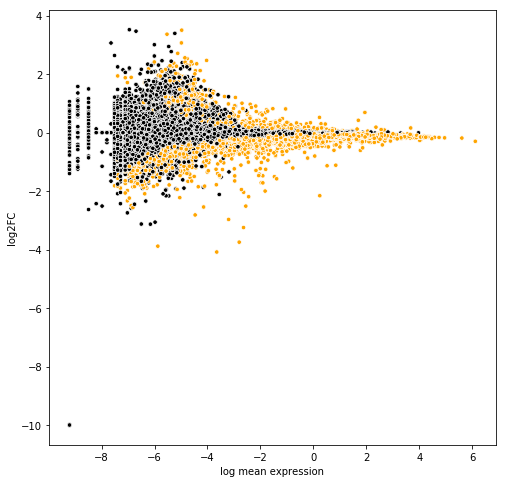

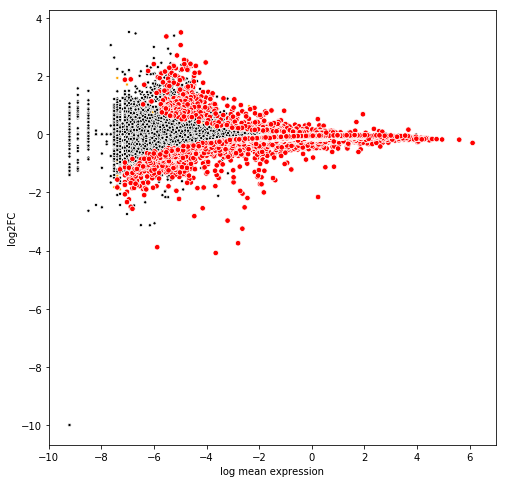

Cluster NSC2:


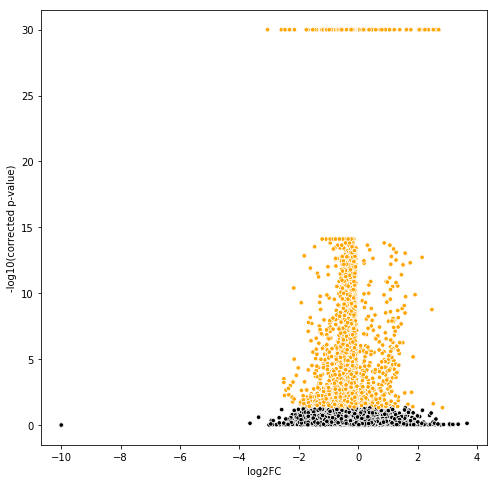

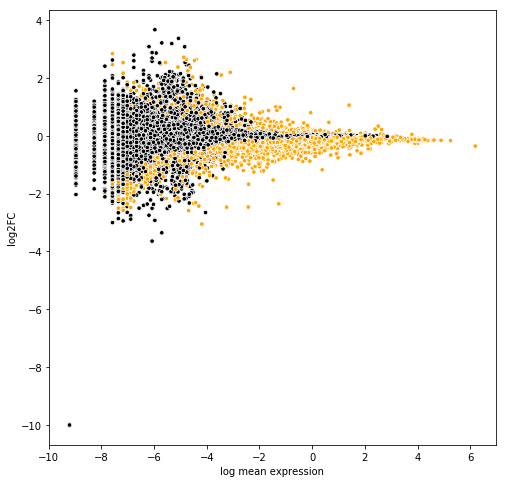

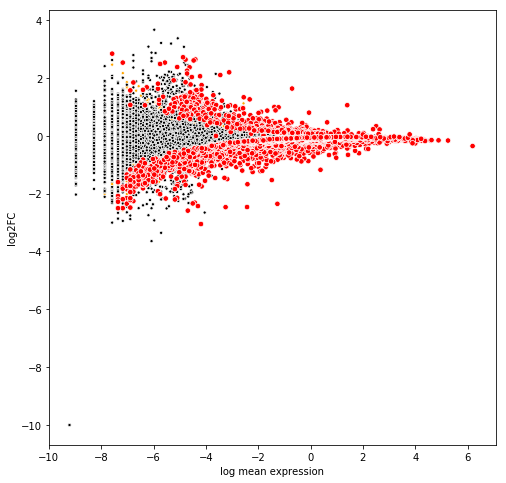

In [18]:
for clust in de_results_coarse:
    print(f'Cluster {clust}:')
    de_results_coarse[clust].plot_volcano()
    de_results_coarse[clust].plot_ma()
    de_results_coarse[clust].plot_ma(size=10, highlight_ids = np.asarray(de_full_res_coarse[clust]['gene'][de_full_res_coarse[clust]['qval'] < 0.05]))


Cluster Glial prec. (myelinating):


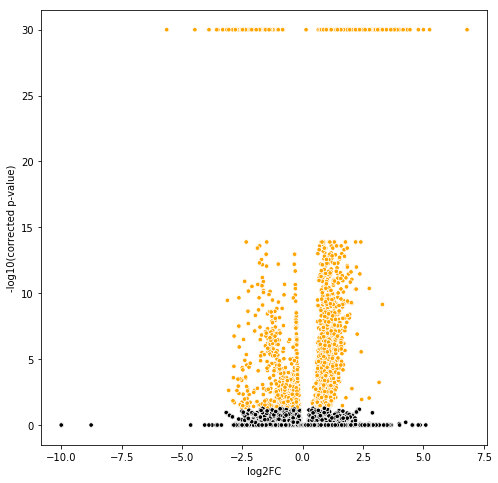

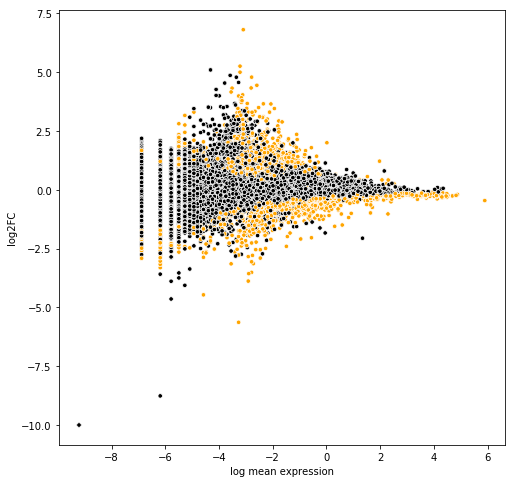

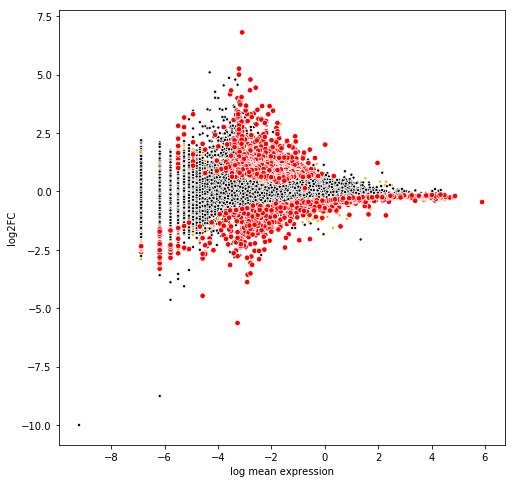

Cluster NCSC:


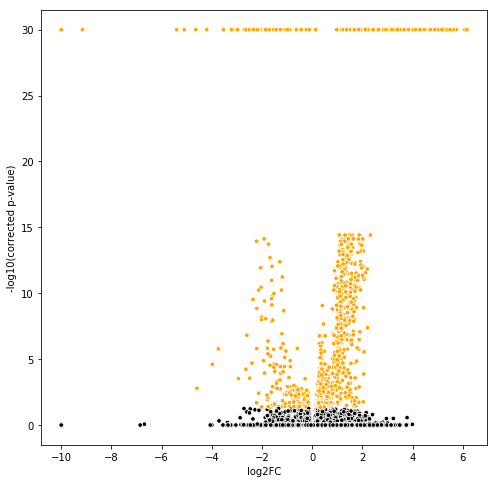

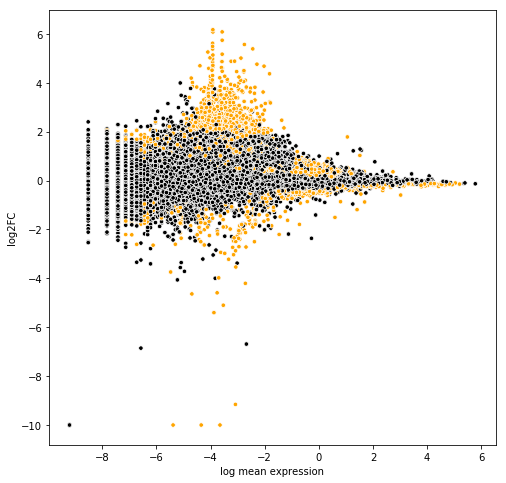

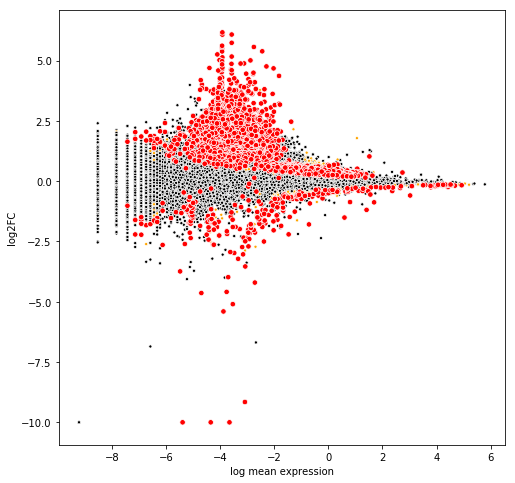

Cluster Apop. NCSC:


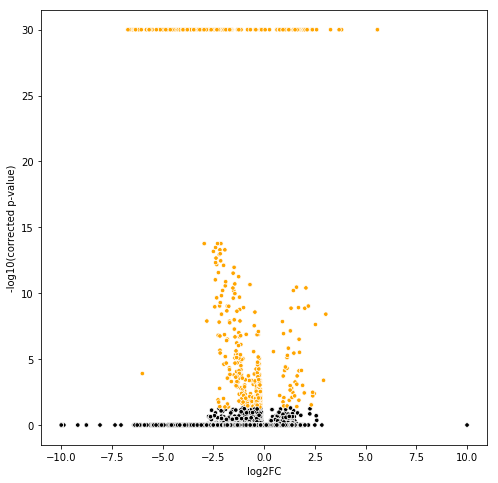

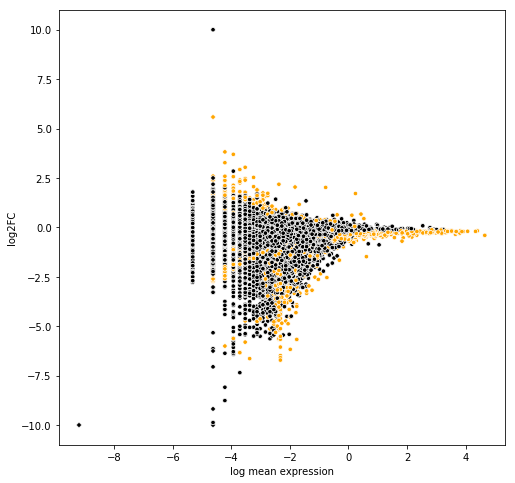

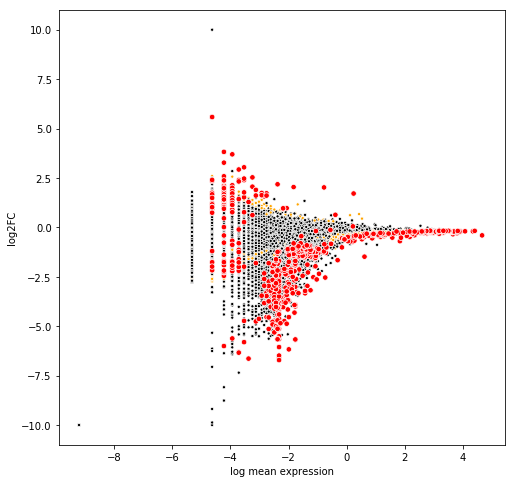

Cluster NSC2:


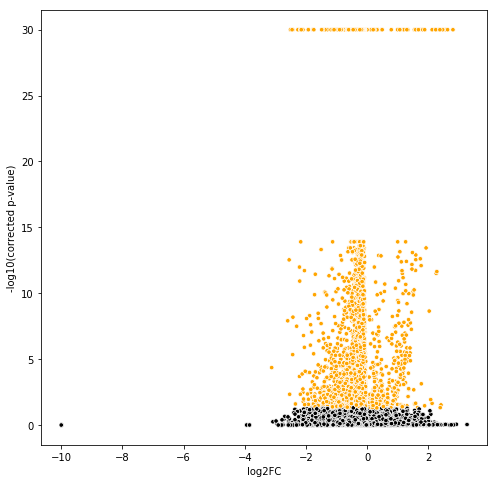

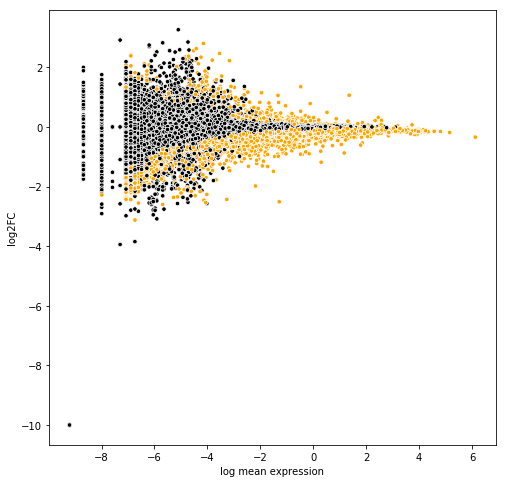

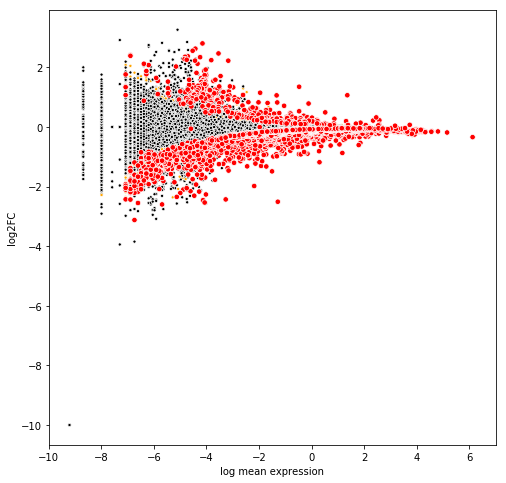

Cluster NSC2 (G2M):


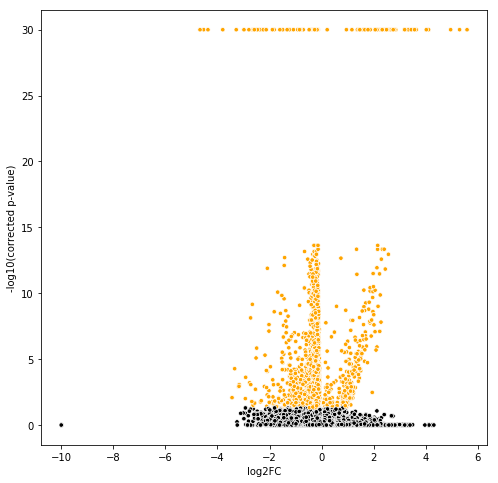

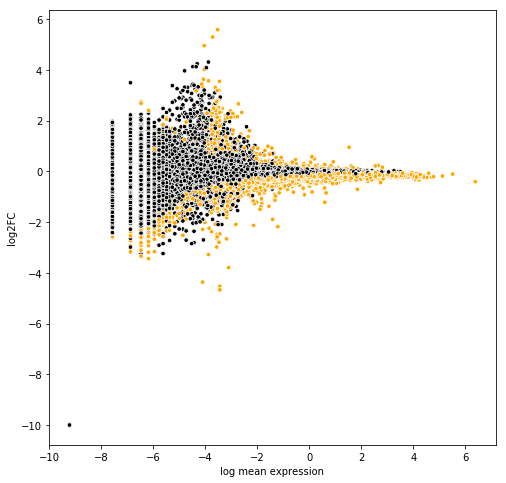

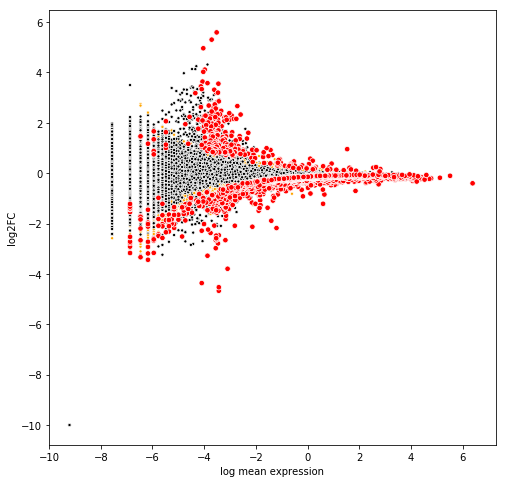

Cluster NSC1:


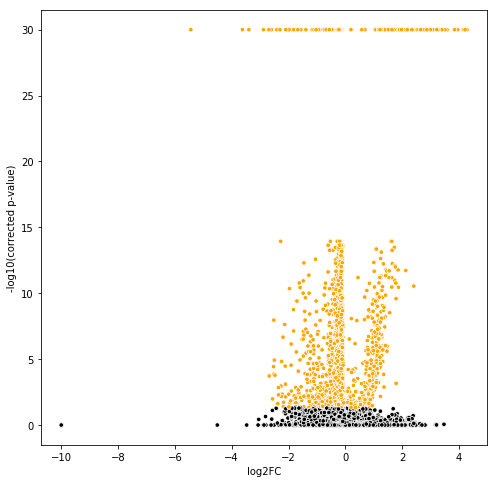

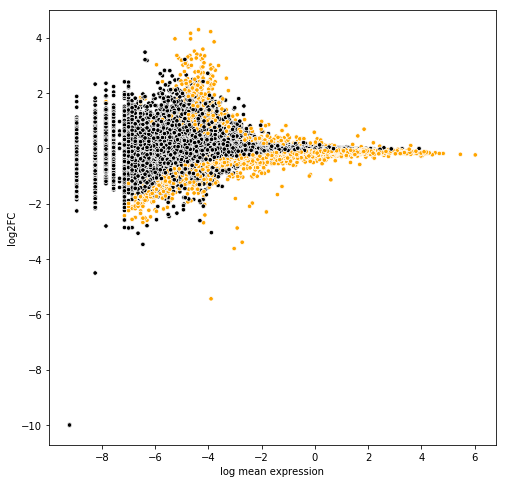

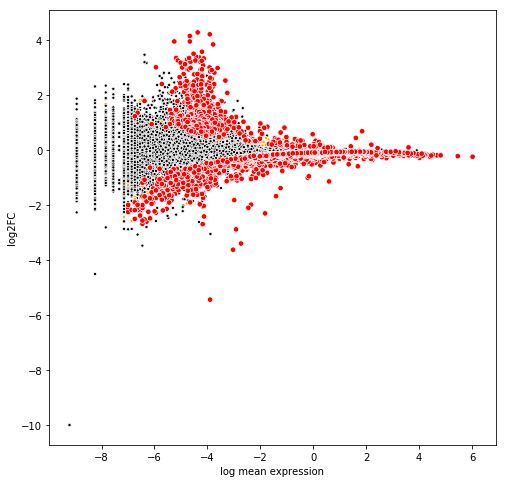

Cluster NSC1 (G2M):


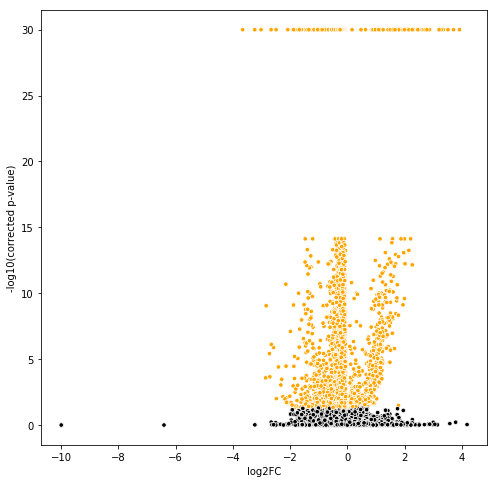

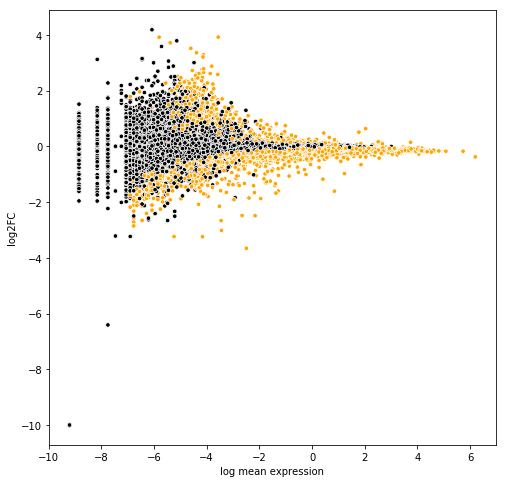

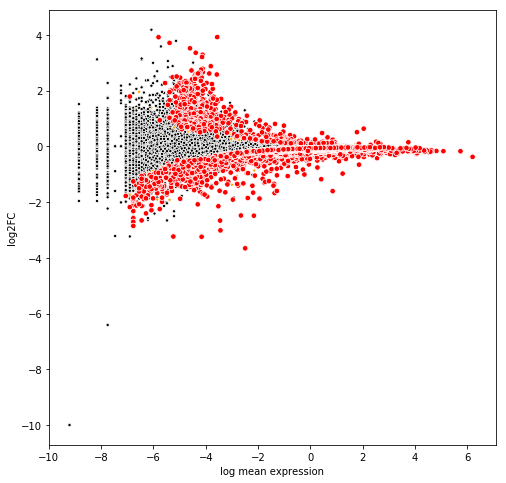

Cluster immature neurons:


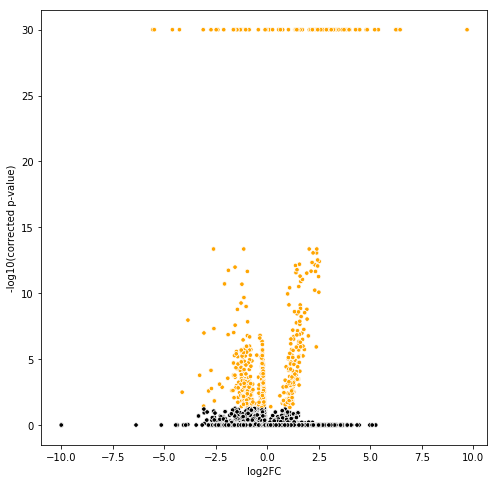

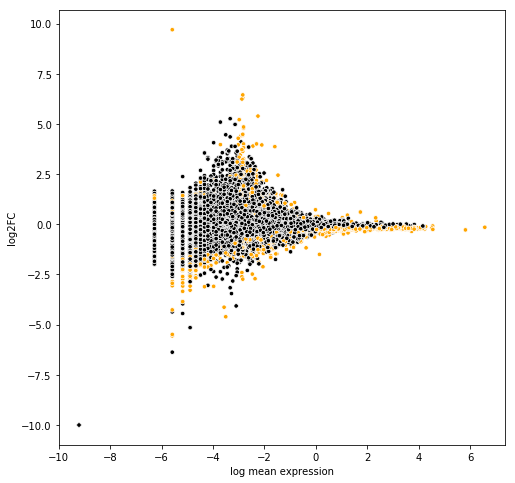

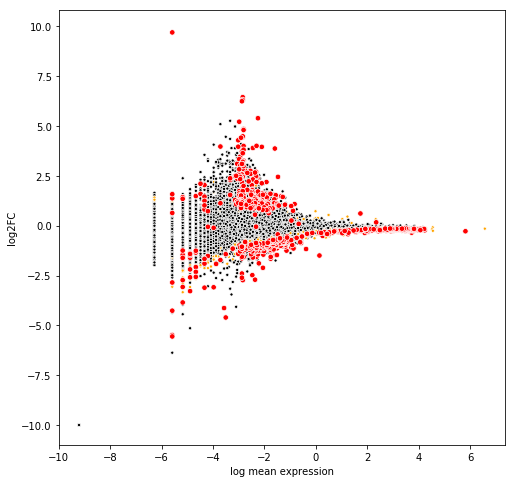

Cluster Apop. NSC:


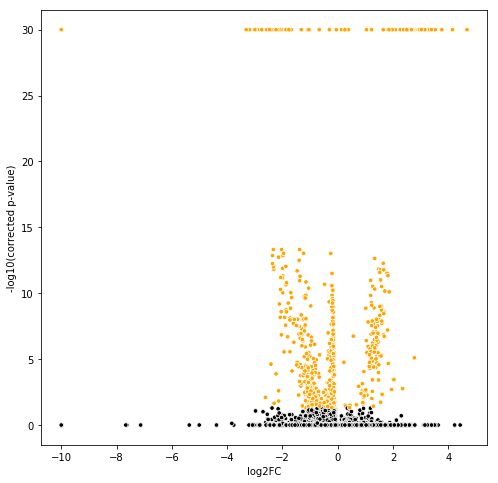

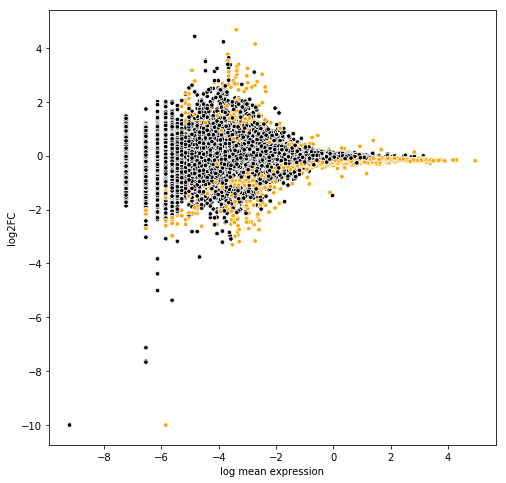

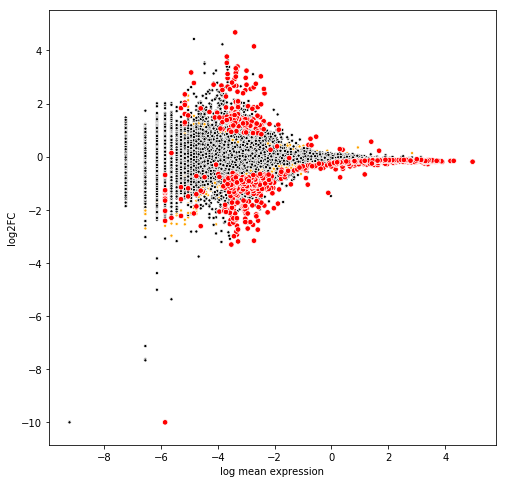

In [25]:
for clust in de_results:
    print(f'Cluster {clust}:')
    de_results[clust].plot_volcano()
    de_results[clust].plot_ma()
    de_results[clust].plot_ma(size=10, highlight_ids = np.asarray(de_full_res[clust]['gene'][de_full_res[clust]['qval'] < 0.05]))


Bulk-like:


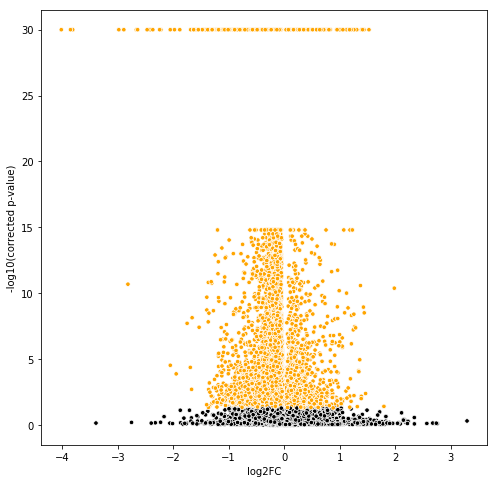

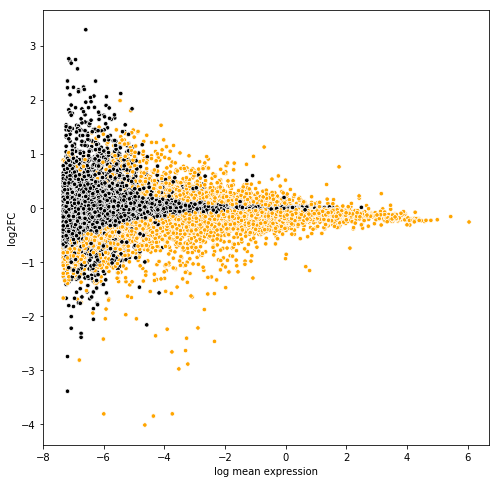

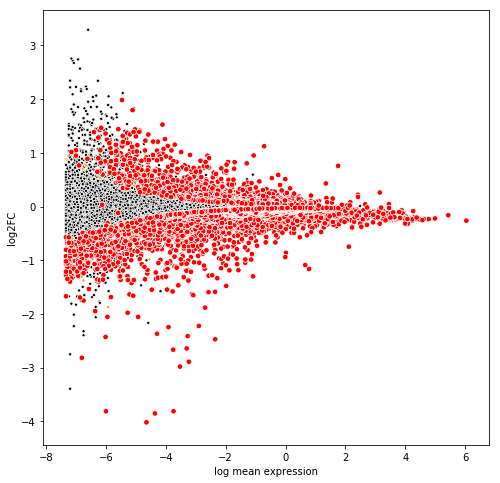

In [26]:
print('Bulk-like:')
test_bulk.plot_volcano()
test_bulk.plot_ma()
test_bulk.plot_ma(size=10, highlight_ids = np.asarray(bulk_res['gene'][bulk_res['qval'] < 0.05]))

## Enrichment analysis

In [19]:
# Plotting functions - 'GProfiler-official version'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import colors
from matplotlib import rcParams


def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)


def plot_enrich(data, n_terms=20, save=False):
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 14, 'font.weight': 'bold'})

    sb.set(style="whitegrid")

    path = plt.scatter(x='recall', y="name", c='p_value', cmap='cool', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=14, fontweight='bold')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight='bold')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=300, format='pdf')

    plt.show()

### Biological Process GO Term enrichment

Background genes for DE testing was changed from genes actually tested to annotated genes. Often there are fewer annotated genes than ones we are testing over. We should actually use the annotated and tested genes as background, but this is currently not possible in gprofiler-official.

In [20]:
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

In [21]:
de_gobp_enrich_coarse = dict()

for clust in de_signif_coarse:
    tmp = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif_coarse[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_gobp_enrich_coarse[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_gobp_enrich_coarse[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_gobp_enrich_coarse[clust].iloc[:50,:]

Cluster NSC1:


p_value  term_size  intersection_size    recall  \
native                                                              
GO:0006996  1.219429e-111       3920               2021  0.515561   
GO:0071840  3.048153e-104       6636               3066  0.462025   
GO:0044237  3.512330e-103      10785               4547  0.421604   
GO:0016043  3.315664e-100       6454               2983  0.462194   
GO:0044260   1.887656e-82       8362               3625  0.433509   
GO:0051641   2.068766e-80       2974               1537  0.516812   
GO:0070727   3.947407e-78       1956               1092  0.558282   
GO:0034613   2.441841e-77       1945               1085  0.557841   
GO:0008152   4.752764e-75      11612               4728  0.407165   
GO:0006807   5.248308e-75      10039               4190  0.417372   
GO:0007049   4.736192e-74       1863               1040  0.558239   
GO:0044238   2.865618e-73      10527               4352  0.413413   
GO:0044267   9.957769e-72       5324               2449  0.459992   
GO:0046907   6.804819e-70       1759                983  0.558840   
GO:0043170   4.252664e-67       9523               3977  0.417620   
GO:0034641   1.902380e-65       6441               2849  0.442323   
GO:0000278   2.947316e-64       1033                636  0.615682   
GO:0016071   1.114738e-63        860                551  0.640698   
GO:0044265   6.393566e-63       1194                709  0.593802   
GO:1903047   1.643117e-61        885                559  0.631638   
GO:0051649   2.119335e-61       2271               1182  0.520476   
GO:0006139   6.500193e-61       5677               2541  0.447596   
GO:0071704   1.201599e-60      11036               4475  0.405491   
GO:0022402   4.176458e-59       1397                793  0.567645   
GO:0008104   2.360776e-58       2863               1420  0.495983   
GO:0006886   2.966435e-57       1162                681  0.586059   
GO:0033365   2.966435e-57        949                581  0.612223   
GO:0009057   1.186069e-56       1431                802  0.560447   
GO:0046483   1.186069e-56       5852               2589  0.442413   
GO:0090304   3.909032e-56       5145               2317  0.450340   
GO:0019538   7.903464e-55       5905               2601  0.440474   
GO:0006725   8.595120e-55       5895               2597  0.440543   
GO:0044085   1.104457e-54       3253               1566  0.481402   
GO:0016032   1.639412e-54        832                519  0.623798   
GO:0044403   1.426203e-53        886                543  0.612867   
GO:0033036   4.828020e-52       3228               1546  0.478934   
GO:1901360   8.071606e-52       6122               2669  0.435969   
GO:0022607   1.140573e-51       3017               1459  0.483593   
GO:0033554   3.025652e-51       2064               1062  0.514535   
GO:0043933   1.847238e-49       2177               1104  0.507120   
GO:0051726   3.224548e-49       1223                689  0.563369   
GO:1901564   7.262280e-49       6854               2928  0.427196   
GO:1901576   1.898819e-47       6193               2675  0.431939   
GO:0044249   1.210299e-46       6102               2637  0.432153   
GO:0033043   1.968002e-46       1284                709  0.552181   
GO:0009058   8.808894e-46       6295               2705  0.429706   
GO:0051128   1.343831e-45       2488               1220  0.490354   
GO:0034645   1.388333e-45       4937               2190  0.443589   
GO:0009059   1.632443e-45       5092               2249  0.441673   
GO:0043412   1.699283e-45       4407               1985  0.450420   

                                                        name  
native                                                        
GO:0006996                            organelle organization  
GO:0071840     cellular component organization or biogenesis  
GO:0044237                        cellular metabolic process  
GO:0016043                   cellular component organization  
GO:0044260          cellular macromolecule metaboli

Cluster NSC2:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0071840  3.363517e-95       6636               2607  0.392857   
GO:0016043  7.731229e-93       6454               2541  0.393709   
GO:0006996  3.541771e-87       3920               1691  0.431378   
GO:0044267  3.267251e-62       5324               2071  0.388993   
GO:0044237  2.235564e-60      10785               3712  0.344182   
GO:0044260  1.141891e-58       8362               2998  0.358527   
GO:0051641  5.927389e-54       2974               1258  0.422999   
GO:0046907  5.631981e-52       1759                819  0.465605   
GO:0044085  1.314638e-51       3253               1345  0.413464   
GO:0007049  2.461384e-51       1863                855  0.458937   
GO:0022607  2.461384e-51       3017               1263  0.418628   
GO:0019538  5.220048e-50       5905               2204  0.373243   
GO:0000278  2.506279e-47       1033                530  0.513069   
GO:0051649  4.694268e-47       2271                988  0.435051   
GO:1903047  5.336578e-47        885                470  0.531073   
GO:0070727  2.582584e-46       1956                873  0.446319   
GO:0034613  5.196451e-46       1945                868  0.446272   
GO:0006807  7.298936e-46      10039               3433  0.341966   
GO:0009057  1.334934e-45       1431                678  0.473795   
GO:0044265  3.267081e-45       1194                587  0.491625   
GO:0043170  1.004604e-43       9523               3272  0.343589   
GO:0051128  1.923336e-43       2488               1051  0.422428   
GO:1901564  2.103503e-42       6854               2463  0.359352   
GO:0022402  2.103503e-42       1397                656  0.469578   
GO:0006613  1.312422e-41        101                 96  0.950495   
GO:0008104  4.412109e-41       2863               1171  0.409012   
GO:0006614  9.579011e-41         96                 92  0.958333   
GO:0008152  1.257155e-40      11612               3857  0.332156   
GO:0043933  1.586250e-39       2177                928  0.426275   
GO:0044238  7.327920e-39      10527               3539  0.336183   
GO:0033036  1.349777e-38       3228               1284  0.397770   
GO:0006413  1.174125e-36        196                147  0.750000   
GO:0072599  2.299910e-36        113                100  0.884956   
GO:0070972  5.095147e-36        137                114  0.832117   
GO:0045047  9.806463e-36        109                 97  0.889908   
GO:0051301  1.011134e-35        609                332  0.545156   
GO:0006464  3.770624e-35       4196               1587  0.378217   
GO:0036211  3.770624e-35       4196               1587  0.378217   
GO:0044403  3.137859e-34        886                439  0.495485   
GO:0016032  7.352203e-34        832                417  0.501202   
GO:0033043  8.339901e-34       1284                588  0.457944   
GO:0016071  1.597246e-33        860                427  0.496512   
GO:0006886  3.055622e-33       1162                541  0.465577   
GO:0051726  1.004997e-31       1223                559  0.457073   
GO:0019222  1.371814e-31       6871               2410  0.350750   
GO:0007010  1.519775e-31       1353                606  0.447894   
GO:0000184  1.615747e-31        122                101  0.827869   
GO:0043412  3.444229e-31       4407               1635  0.371001   
GO:0033365  6.498056e-31        949                454  0.478398   
GO:0048519  8.422661e-31       5596               2010  0.359185   

                                                         name  
native                                                         
GO:0071840      cellular component organization or biogenesis  
GO:0016043                    cellular component organization  
GO:0006996                             organelle organization  
GO:0044267                 cellular protein metabolic process  
GO:0044237                         cellular metabolic process  
GO:0044260           cellular ma

In [29]:
de_gobp_enrich = dict()

for clust in de_signif:
    tmp = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_gobp_enrich[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_gobp_enrich[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_gobp_enrich[clust].iloc[:50,:]

Cluster Glial prec. (myelinating):


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0006614  3.422126e-52         96                 72  0.750000   
GO:0045047  3.202828e-50        109                 75  0.688073   
GO:0000184  3.707878e-50        122                 79  0.647541   
GO:0006613  3.707878e-50        101                 72  0.712871   
GO:0072599  7.917802e-49        113                 75  0.663717   
GO:0019083  5.190567e-43        177                 88  0.497175   
GO:0019080  1.274865e-42        191                 91  0.476440   
GO:0000956  3.502373e-42        210                 95  0.452381   
GO:0070972  2.075554e-40        137                 75  0.547445   
GO:0006413  1.827106e-38        197                 88  0.446701   
GO:0006612  2.132589e-35        194                 84  0.432990   
GO:0006402  1.242047e-28        368                109  0.296196   
GO:0006401  2.905611e-26        402                111  0.276119   
GO:0006605  1.212243e-25        427                114  0.266979   
GO:0090304  3.321984e-22       5216                637  0.122124   
GO:0044237  3.368557e-22      10862               1134  0.104401   
GO:0090150  1.771683e-21        328                 91  0.277439   
GO:0034655  3.184051e-21        539                123  0.228200   
GO:0006139  5.746638e-21       5749                682  0.118629   
GO:0072594  1.588656e-20        563                125  0.222025   
GO:0046483  3.401395e-20       5925                695  0.117300   
GO:1901360  1.503311e-19       6193                717  0.115776   
GO:0016032  1.827863e-19        831                159  0.191336   
GO:0006725  2.139476e-19       5965                695  0.116513   
GO:0034641  3.099492e-19       6504                744  0.114391   
GO:0046700  4.795172e-19        586                125  0.213311   
GO:0044270  5.192940e-19        587                125  0.212947   
GO:0016070  5.192940e-19       4720                575  0.121822   
GO:0044403  7.482047e-19        883                164  0.185730   
GO:0006412  1.618409e-18        728                143  0.196429   
GO:0044260  1.088189e-17       8435                909  0.107765   
GO:0043043  1.241617e-17        752                144  0.191489   
GO:0019439  1.241617e-17        602                124  0.205980   
GO:0044265  1.361151e-17       1178                197  0.167233   
GO:1901361  1.645354e-17        634                128  0.201893   
GO:0008152  2.597466e-17      11663               1177  0.100917   
GO:0016071  8.955370e-17        855                155  0.181287   
GO:0043604  1.524036e-16        892                159  0.178251   
GO:0044419  1.524036e-16        932                164  0.175966   
GO:0033365  1.618812e-16        941                165  0.175345   
GO:0044238  1.890207e-16      10607               1087  0.102479   
GO:0034470  1.963232e-16        375                 89  0.237333   
GO:0042254  1.472506e-15        294                 75  0.255102   
GO:0044249  1.820287e-15       6165                694  0.112571   
GO:0034645  1.898950e-15       5012                586  0.116919   
GO:0009057  2.352102e-15       1418                218  0.153738   
GO:1901576  2.603624e-15       6251                701  0.112142   
GO:0009058  2.888427e-15       6352                710  0.111776   
GO:0006807  5.613803e-15      10108               1038  0.102691   
GO:0009059  1.160566e-14       5160                596  0.115504   

                                                         name  
native                                                         
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0045047                            protein targeting to ER  
GO:0000184  nuclear-transcribed mRNA catabolic process, no...  
GO:0006613      cotranslational protein targeting to membrane  
GO:0072599  establishment of protein localization to endop...  
GO:0019083                      

Cluster NCSC:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0006605  2.256946e-07        427                 76  0.177986   
GO:0044237  2.782884e-07      10862                985  0.090683   
GO:0034641  3.857905e-07       6504                634  0.097478   
GO:0006614  3.857905e-07         96                 29  0.302083   
GO:0070126  8.761769e-07         88                 27  0.306818   
GO:0006613  9.812611e-07        101                 29  0.287129   
GO:0045047  1.327414e-06        109                 30  0.275229   
GO:0070125  2.138228e-06         87                 26  0.298851   
GO:0072599  2.638049e-06        113                 30  0.265487   
GO:0006886  4.143893e-06       1158                148  0.127807   
GO:0006415  4.143893e-06        103                 28  0.271845   
GO:0008152  5.715191e-06      11663               1033  0.088571   
GO:0032543  1.119740e-05        135                 32  0.237037   
GO:0090304  1.163610e-05       5216                511  0.097968   
GO:0006807  1.163610e-05      10108                910  0.090028   
GO:0006612  1.163610e-05        194                 40  0.206186   
GO:0140053  2.354802e-05        162                 35  0.216049   
GO:0044238  2.471889e-05      10607                946  0.089186   
GO:0010467  2.733277e-05       5656                545  0.096358   
GO:0044271  2.953496e-05       4999                489  0.097820   
GO:0070972  3.599842e-05        137                 31  0.226277   
GO:0006414  4.871722e-05        139                 31  0.223022   
GO:0016070  5.191276e-05       4720                463  0.098093   
GO:0072594  5.582091e-05        563                 81  0.143872   
GO:0046907  8.423124e-05       1754                198  0.112885   
GO:0006725  8.871357e-05       5965                566  0.094887   
GO:0071704  9.954289e-05      11095                978  0.088148   
GO:0046483  1.000133e-04       5925                562  0.094852   
GO:0090150  1.845245e-04        328                 53  0.161585   
GO:0006139  1.845245e-04       5749                545  0.094799   
GO:0000184  2.549925e-04        122                 27  0.221311   
GO:0044249  3.629478e-04       6165                577  0.093593   
GO:0000956  3.749364e-04        210                 38  0.180952   
GO:0006518  3.749364e-04        891                111  0.124579   
GO:0009058  3.749364e-04       6352                592  0.093199   
GO:0044260  3.749364e-04       8435                762  0.090338   
GO:0034645  3.749364e-04       5012                480  0.095770   
GO:0033365  3.749364e-04        941                116  0.123273   
GO:0006413  4.902657e-04        197                 36  0.182741   
GO:0006412  5.017842e-04        728                 94  0.129121   
GO:1901360  5.337464e-04       6193                577  0.093170   
GO:0043624  5.848450e-04        216                 38  0.175926   
GO:0032984  5.848450e-04        327                 51  0.155963   
GO:0043043  5.848450e-04        752                 96  0.127660   
GO:0022613  5.848450e-04        463                 66  0.142549   
GO:0051649  6.662635e-04       2253                237  0.105193   
GO:0019083  6.662635e-04        177                 33  0.186441   
GO:0042254  6.662635e-04        294                 47  0.159864   
GO:0070727  6.927985e-04       1936                208  0.107438   
GO:0034613  6.927985e-04       1925                207  0.107532   

                                                         name  
native                                                         
GO:0006605                                  protein targeting  
GO:0044237                         cellular metabolic process  
GO:0034641       cellular nitrogen compound metabolic process  
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0070126            mitochondrial translational termination  
GO:0006613      cotranslational 

Cluster Apop. NCSC:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0006614  3.874801e-65         96                 59  0.614583   
GO:0006613  1.605149e-63        101                 59  0.584158   
GO:0045047  6.281367e-61        109                 59  0.541284   
GO:0072599  8.735461e-60        113                 59  0.522124   
GO:0070972  1.825893e-53        137                 59  0.430657   
GO:0000184  1.222632e-52        122                 56  0.459016   
GO:0006413  1.654947e-46        197                 62  0.314721   
GO:0019080  6.387628e-45        191                 60  0.314136   
GO:0019083  1.376529e-44        177                 58  0.327684   
GO:0000956  1.647260e-43        210                 61  0.290476   
GO:0006612  2.435869e-43        194                 59  0.304124   
GO:0006402  4.437614e-34        368                 67  0.182065   
GO:0006605  1.291530e-33        427                 71  0.166276   
GO:0090150  2.146038e-33        328                 63  0.192073   
GO:0072594  2.325866e-32        563                 79  0.140320   
GO:0006401  9.992860e-32        402                 67  0.166667   
GO:0006412  4.595839e-29        728                 85  0.116758   
GO:0043043  4.690332e-28        752                 85  0.113032   
GO:0034655  5.951388e-28        539                 72  0.133581   
GO:0046700  1.987646e-26        586                 73  0.124573   
GO:0044270  2.112231e-26        587                 73  0.124361   
GO:0044403  7.136391e-26        883                 89  0.100793   
GO:0016032  9.320851e-26        831                 86  0.103490   
GO:0019439  9.320851e-26        602                 73  0.121262   
GO:0044419  1.518052e-25        932                 91  0.097639   
GO:1901361  2.270504e-24        634                 73  0.115142   
GO:0006518  2.513567e-24        891                 87  0.097643   
GO:0043604  1.209210e-23        892                 86  0.096413   
GO:0033365  2.020554e-21        941                 85  0.090329   
GO:0044265  1.204866e-20       1178                 95  0.080645   
GO:0072657  7.542546e-20        624                 66  0.105769   
GO:0016071  9.109048e-20        855                 78  0.091228   
GO:0009057  9.784583e-20       1418                104  0.073343   
GO:0006886  1.658127e-19       1158                 92  0.079447   
GO:0043603  5.577593e-19       1157                 91  0.078652   
GO:0046907  8.840333e-17       1754                112  0.063854   
GO:1901566  7.217789e-16       1881                115  0.061138   
GO:0070727  6.197398e-15       1936                115  0.059401   
GO:0034613  1.083304e-14       1925                114  0.059221   
GO:0002181  1.145510e-14         99                 24  0.242424   
GO:0042254  1.396015e-14        294                 39  0.132653   
GO:1901575  1.838149e-14       2208                124  0.056159   
GO:0044248  7.369026e-14       2276                125  0.054921   
GO:0022613  7.829342e-14        463                 48  0.103672   
GO:0009056  2.544315e-13       2652                137  0.051659   
GO:0044267  4.545503e-13       5329                222  0.041659   
GO:0015031  7.604259e-13       2074                115  0.055448   
GO:0045184  2.237373e-12       2189                118  0.053906   
GO:0015833  2.625089e-12       2112                115  0.054451   
GO:0051649  6.866294e-12       2253                119  0.052818   

                                                         name  
native                                                         
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0006613      cotranslational protein targeting to membrane  
GO:0045047                            protein targeting to ER  
GO:0072599  establishment of protein localization to endop...  
GO:0070972      protein localization to endoplasmic reticulum  
GO:0000184  nuclear-transcribed 

Cluster NSC2:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0071840  7.532144e-66       6623               2073  0.313000   
GO:0016043  1.222072e-63       6441               2018  0.313305   
GO:0046907  8.827755e-61       1754                722  0.411631   
GO:0051641  2.935322e-59       2945               1070  0.363328   
GO:0006996  8.736126e-54       3898               1316  0.337609   
GO:0070727  1.261972e-52       1936                755  0.389979   
GO:0034613  9.728609e-52       1925                749  0.389091   
GO:0051649  2.231658e-50       2253                842  0.373724   
GO:0006613  2.460586e-50        101                 96  0.950495   
GO:0006614  3.975062e-49         96                 92  0.958333   
GO:0044267  7.390897e-49       5329               1674  0.314130   
GO:0070972  4.272268e-47        137                115  0.839416   
GO:0072599  1.189498e-46        113                101  0.893805   
GO:0008104  2.130252e-46       2835                995  0.350970   
GO:0045047  8.066421e-46        109                 98  0.899083   
GO:0033036  2.458565e-44       3200               1089  0.340313   
GO:0006886  3.173908e-44       1158                491  0.424007   
GO:0009057  1.548581e-42       1418                568  0.400564   
GO:0019538  6.154034e-40       5915               1784  0.301606   
GO:0044265  7.466954e-40       1178                486  0.412564   
GO:0045184  1.917776e-39       2189                787  0.359525   
GO:0006413  2.110974e-39        197                137  0.695431   
GO:0015031  3.012897e-39       2074                753  0.363067   
GO:0072657  3.012897e-39        624                302  0.483974   
GO:0090150  2.269675e-38        328                191  0.582317   
GO:0015833  1.600018e-37       2112                758  0.358902   
GO:0044237  2.004015e-37      10862               2958  0.272326   
GO:1901564  6.478760e-37       6860               2005  0.292274   
GO:0042886  1.445748e-36       2145                764  0.356177   
GO:0044085  1.611403e-34       3290               1074  0.326444   
GO:0044260  5.909824e-34       8435               2373  0.281328   
GO:0022607  8.858524e-34       3055               1007  0.329624   
GO:0006518  1.514691e-33        891                378  0.424242   
GO:0051128  1.613380e-32       2457                837  0.340659   
GO:0006612  2.165383e-32        194                127  0.654639   
GO:0006412  1.559253e-31        728                320  0.439560   
GO:0043043  3.487522e-31        752                327  0.434840   
GO:0043604  3.778457e-31        892                372  0.417040   
GO:0000184  9.450929e-31        122                 92  0.754098   
GO:0033365  1.324502e-30        941                386  0.410202   
GO:0072594  2.197204e-30        563                262  0.465364   
GO:0016032  3.222978e-30        831                350  0.421179   
GO:0006605  3.481816e-30        427                214  0.501171   
GO:0044403  5.085206e-30        883                366  0.414496   
GO:0071705  8.266283e-30       2447                823  0.336330   
GO:0043603  2.473611e-29       1157                449  0.388073   
GO:0048519  1.459227e-28       5544               1632  0.294372   
GO:0019080  3.824618e-28        191                120  0.628272   
GO:0044248  5.300011e-28       2276                768  0.337434   
GO:0043933  5.502332e-28       2219                752  0.338891   

                                                         name  
native                                                         
GO:0071840      cellular component organization or biogenesis  
GO:0016043                    cellular component organization  
GO:0046907                            intracellular transport  
GO:0051641                              cellular localization  
GO:0006996                             organelle organization  
GO:0070727                cellul

Cluster NSC2 (G2M):


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0006613  2.264170e-58        101                 88  0.871287   
GO:0006614  7.006677e-58         96                 85  0.885417   
GO:0006996  6.413111e-55       3898                851  0.218317   
GO:0045047  3.448227e-53        109                 88  0.807339   
GO:0072599  3.424519e-52        113                 89  0.787611   
GO:0071840  1.347725e-51       6623               1253  0.189189   
GO:0000184  6.533447e-50        122                 91  0.745902   
GO:0016043  3.917462e-49       6441               1218  0.189101   
GO:0070972  1.873781e-46        137                 94  0.686131   
GO:0007049  1.427436e-42       1854                467  0.251888   
GO:0006413  1.054353e-41        197                110  0.558376   
GO:0000956  1.152096e-41        210                114  0.542857   
GO:0000278  2.469953e-41       1022                305  0.298434   
GO:1903047  1.542242e-37        876                267  0.304795   
GO:0051641  4.172770e-36       2945                635  0.215620   
GO:0022402  3.406378e-34       1388                359  0.258646   
GO:0051301  7.756249e-33        610                201  0.329508   
GO:0006612  3.178731e-32        194                 98  0.505155   
GO:0019080  3.751379e-32        191                 97  0.507853   
GO:0051649  8.284768e-32       2253                505  0.224146   
GO:0019083  1.679437e-31        177                 92  0.519774   
GO:0006402  6.455968e-31        368                142  0.385870   
GO:0044267  1.056022e-30       5329                984  0.184650   
GO:0044265  1.225988e-30       1178                310  0.263158   
GO:0016032  1.766576e-30        831                242  0.291215   
GO:0090150  3.024565e-30        328                131  0.399390   
GO:0034613  4.041559e-30       1925                443  0.230130   
GO:0070727  7.609661e-30       1936                444  0.229339   
GO:0044085  1.273162e-29       3290                667  0.202736   
GO:0046907  1.839304e-29       1754                411  0.234322   
GO:0009057  1.839304e-29       1418                351  0.247532   
GO:0033365  2.316933e-29        941                261  0.277365   
GO:0044403  3.999353e-29        883                249  0.281993   
GO:0006401  1.192128e-28        402                146  0.363184   
GO:0022607  1.814891e-27       3055                621  0.203273   
GO:0044260  1.814891e-27       8435               1409  0.167042   
GO:0006412  4.023831e-26        728                211  0.289835   
GO:0043043  8.915806e-26        752                215  0.285904   
GO:0008104  9.446760e-26       2835                579  0.204233   
GO:0044419  1.074962e-25        932                250  0.268240   
GO:0006518  1.142689e-25        891                242  0.271605   
GO:0051726  1.151724e-25       1210                302  0.249587   
GO:0007059  1.472660e-25        315                120  0.380952   
GO:0006886  8.200287e-25       1158                290  0.250432   
GO:0044772  1.052348e-24        588                179  0.304422   
GO:0007017  3.660208e-24        757                212  0.280053   
GO:0044237  5.185209e-23      10862               1709  0.157338   
GO:0006605  5.756833e-23        427                141  0.330211   
GO:0033043  7.478140e-23       1267                304  0.239937   
GO:0043933  8.554012e-23       2219                467  0.210455   

                                                         name  
native                                                         
GO:0006613      cotranslational protein targeting to membrane  
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0006996                             organelle organization  
GO:0045047                            protein targeting to ER  
GO:0072599  establishment of protein localization to endop...  
GO:0071840      cellular compone

Cluster NSC1:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0044237  5.643317e-56      10862               2517  0.231725   
GO:0046907  5.772345e-53       1754                606  0.345496   
GO:0044265  1.755564e-51       1178                450  0.382003   
GO:0070972  1.755564e-51        137                111  0.810219   
GO:0006614  4.187053e-50         96                 88  0.916667   
GO:0045047  1.070607e-49        109                 95  0.871560   
GO:0072599  1.503839e-49        113                 97  0.858407   
GO:0006613  6.055425e-49        101                 90  0.891089   
GO:0051641  4.043992e-47       2945                875  0.297114   
GO:0071840  1.034146e-46       6623               1665  0.251397   
GO:0009057  1.883518e-46       1418                501  0.353315   
GO:0000184  2.716820e-46        122                 99  0.811475   
GO:0070727  8.815104e-46       1936                630  0.325413   
GO:0034613  1.031875e-45       1925                627  0.325714   
GO:0006413  1.229873e-45        197                132  0.670051   
GO:0006996  6.127189e-44       3898               1078  0.276552   
GO:0008152  1.005728e-42      11663               2607  0.223527   
GO:0000956  1.005728e-42        210                134  0.638095   
GO:0016043  3.776023e-42       6441               1608  0.249651   
GO:0006886  5.055209e-42       1158                421  0.363558   
GO:0006402  8.592910e-42        368                190  0.516304   
GO:0016071  1.772999e-41        855                337  0.394152   
GO:0051649  1.887498e-41       2253                693  0.307590   
GO:0016032  2.120020e-41        831                330  0.397112   
GO:0044403  1.062221e-40        883                343  0.388448   
GO:0044248  3.475930e-39       2276                691  0.303603   
GO:0006401  3.801927e-39        402                197  0.490050   
GO:0006518  1.996487e-38        891                340  0.381594   
GO:0033365  3.804294e-38        941                353  0.375133   
GO:0043043  1.921312e-37        752                299  0.397606   
GO:0006412  2.289234e-37        728                292  0.401099   
GO:0008104  1.882785e-36       2835                811  0.286067   
GO:0043933  4.115594e-36       2219                667  0.300586   
GO:0044419  7.264019e-36        932                345  0.370172   
GO:0043604  8.192844e-36        892                334  0.374439   
GO:0034655  1.777118e-35        539                233  0.432282   
GO:0090150  4.419141e-35        328                166  0.506098   
GO:0072594  6.522057e-35        563                239  0.424512   
GO:0019080  7.005342e-35        191                117  0.612565   
GO:0009056  1.362641e-34       2652                762  0.287330   
GO:0044085  1.367903e-34       3290                906  0.275380   
GO:0044267  1.562675e-34       5329               1344  0.252205   
GO:0045184  1.768606e-34       2189                654  0.298767   
GO:0006605  1.848053e-33        427                195  0.456674   
GO:0015031  2.303366e-33       2074                623  0.300386   
GO:0006807  3.678741e-33      10108               2280  0.225564   
GO:0033036  3.783611e-33       3200                880  0.275000   
GO:0043603  8.724885e-33       1157                396  0.342264   
GO:0015833  1.538473e-32       2112                629  0.297822   
GO:1901575  2.115785e-32       2208                651  0.294837   

                                                         name  
native                                                         
GO:0044237                         cellular metabolic process  
GO:0046907                            intracellular transport  
GO:0044265           cellular macromolecule catabolic process  
GO:0070972      protein localization to endoplasmic reticulum  
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0045047                      

Cluster NSC1 (G2M):


p_value  term_size  intersection_size    recall  \
native                                                              
GO:0006996  6.790352e-103       3898               1775  0.455362   
GO:0044237   3.836566e-96      10862               3980  0.366415   
GO:0071840   5.573091e-91       6623               2662  0.401933   
GO:0016043   1.659541e-88       6441               2594  0.402732   
GO:0044260   9.360053e-82       8435               3203  0.379727   
GO:0007049   9.439904e-74       1854                934  0.503776   
GO:0051641   3.385864e-73       2945               1343  0.456027   
GO:0006807   5.082197e-71      10108               3670  0.363079   
GO:0008152   2.984613e-69      11663               4117  0.352997   
GO:0070727   6.601816e-69       1936                953  0.492252   
GO:0034613   2.840856e-68       1925                947  0.491948   
GO:0043170   1.317596e-66       9580               3494  0.364718   
GO:0044267   4.886723e-66       5329               2145  0.402515   
GO:0034641   6.602468e-66       6504               2530  0.388991   
GO:0044238   1.219466e-65      10607               3796  0.357877   
GO:0016071   2.445006e-62        855                499  0.583626   
GO:0000278   3.679102e-61       1022                568  0.555773   
GO:0046907   6.989563e-61       1754                861  0.490878   
GO:0044265   7.730163e-61       1178                632  0.536503   
GO:0006139   1.309853e-58       5749               2254  0.392068   
GO:0016032   1.681241e-58        831                481  0.578821   
GO:0022402   8.890128e-57       1388                707  0.509366   
GO:0009057   4.786674e-56       1418                717  0.505642   
GO:0090304   1.607609e-55       5216               2065  0.395897   
GO:1903047   2.139027e-55        876                494  0.563927   
GO:0071704   3.626079e-55      11095               3896  0.351149   
GO:0044403   5.933347e-55        883                496  0.561721   
GO:0046483   1.572759e-54       5925               2294  0.387173   
GO:0051649   9.273474e-54       2253               1028  0.456281   
GO:0006725   2.208469e-53       5965               2302  0.385918   
GO:0008104   8.641458e-53       2835               1236  0.435979   
GO:0033365   1.832025e-52        941                515  0.547290   
GO:0019538   1.628931e-50       5915               2273  0.384277   
GO:0034645   3.975973e-50       5012               1974  0.393855   
GO:1901576   4.487410e-50       6251               2380  0.380739   
GO:0044249   4.735333e-50       6165               2352  0.381509   
GO:1901360   4.775383e-50       6193               2361  0.381237   
GO:0009059   1.119980e-49       5160               2021  0.391667   
GO:0009058   1.926243e-48       6352               2405  0.378621   
GO:0044271   3.489645e-48       4999               1961  0.392278   
GO:0044419   1.734134e-47        932                500  0.536481   
GO:0033036   4.180994e-47       3200               1344  0.420000   
GO:0033554   1.370510e-46       2075                939  0.452530   
GO:0044085   3.096230e-46       3290               1372  0.417021   
GO:0051726   3.097229e-46       1210                609  0.503306   
GO:0010467   4.089984e-46       5656               2168  0.383310   
GO:0033043   4.445001e-46       1267                631  0.498027   
GO:0006886   1.008211e-45       1158                587  0.506908   
GO:0022607   1.486657e-45       3055               1287  0.421277   
GO:0016070   2.674571e-45       4720               1855  0.393008   

                                                        name  
native                                                        
GO:0006996                            organelle organization  
GO:0044237                        cellular metabolic process  
GO:0071840     cellular component organization or biogenesis  
GO:0016043                   cellular component organization  
GO:0044260          cellular macromolecule metaboli

Cluster immature neurons:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0006614  1.982641e-88         96                 70  0.729167   
GO:0006613  4.156362e-86        101                 70  0.693069   
GO:0045047  1.443944e-82        109                 70  0.642202   
GO:0072599  5.190347e-81        113                 70  0.619469   
GO:0000184  1.812795e-79        122                 71  0.581967   
GO:0070972  7.735699e-73        137                 70  0.510949   
GO:0006413  1.231815e-70        197                 78  0.395939   
GO:0019080  5.607432e-69        191                 76  0.397906   
GO:0019083  1.506876e-67        177                 73  0.412429   
GO:0006612  3.380654e-61        194                 71  0.365979   
GO:0000956  3.807169e-61        210                 73  0.347619   
GO:0006402  1.801957e-48        368                 79  0.214674   
GO:0090150  5.358706e-48        328                 75  0.228659   
GO:0006401  1.609675e-46        402                 80  0.199005   
GO:0006605  2.003016e-43        427                 79  0.185012   
GO:0006412  4.811497e-41        728                 97  0.133242   
GO:0043043  8.057983e-40        752                 97  0.128989   
GO:0072594  6.761752e-39        563                 84  0.149201   
GO:0034655  1.202161e-37        539                 81  0.150278   
GO:0006518  4.504238e-35        891                 99  0.111111   
GO:0046700  5.995378e-35        586                 81  0.138225   
GO:0044270  6.499915e-35        587                 81  0.137990   
GO:0043604  2.561876e-34        892                 98  0.109865   
GO:0019439  3.895199e-34        602                 81  0.134551   
GO:0072657  5.288388e-33        624                 81  0.129808   
GO:1901361  1.630632e-32        634                 81  0.127760   
GO:0016032  2.570218e-32        831                 92  0.110710   
GO:0044403  5.569588e-31        883                 93  0.105323   
GO:0016071  7.247200e-30        855                 90  0.105263   
GO:0044419  3.729683e-29        932                 93  0.099785   
GO:0043603  1.825117e-28       1157                103  0.089023   
GO:0033365  3.794714e-28        941                 92  0.097768   
GO:0044265  3.505249e-27       1178                102  0.086587   
GO:0002181  1.142768e-23         99                 31  0.313131   
GO:0009057  4.116550e-23       1418                106  0.074753   
GO:0006886  1.000146e-22       1158                 94  0.081174   
GO:0046907  4.305790e-21       1754                116  0.066135   
GO:1901566  4.128476e-20       1881                119  0.063264   
GO:0044271  6.383688e-19       4999                218  0.043609   
GO:0034645  8.801183e-19       5012                218  0.043496   
GO:0034641  1.202111e-18       6504                259  0.039822   
GO:0006725  4.262771e-18       5965                243  0.040738   
GO:0010629  4.305912e-18       2102                123  0.058516   
GO:0006139  4.305912e-18       5749                237  0.041225   
GO:0046483  8.858287e-18       5925                241  0.040675   
GO:0009059  1.446650e-17       5160                219  0.042442   
GO:0051649  5.364873e-17       2253                126  0.055925   
GO:1901360  6.153611e-17       6193                246  0.039722   
GO:0090304  1.316400e-16       5216                218  0.041794   
GO:0010468  3.671033e-16       4703                202  0.042951   

                                                         name  
native                                                         
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0006613      cotranslational protein targeting to membrane  
GO:0045047                            protein targeting to ER  
GO:0072599  establishment of protein localization to endop...  
GO:0000184  nuclear-transcribed mRNA catabolic process, no...  
GO:0070972      protein localiza

Cluster Apop. NSC:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0006614  4.728667e-95         96                 77  0.802083   
GO:0006613  3.836730e-92        101                 77  0.762376   
GO:0000184  4.507122e-89        122                 81  0.663934   
GO:0045047  5.552485e-88        109                 77  0.706422   
GO:0072599  4.346327e-86        113                 77  0.681416   
GO:0070972  1.870776e-76        137                 77  0.562044   
GO:0006413  2.013039e-73        197                 86  0.436548   
GO:0019083  1.473824e-72        177                 82  0.463277   
GO:0019080  1.249007e-70        191                 83  0.434555   
GO:0000956  7.160998e-68        210                 84  0.400000   
GO:0006612  4.991013e-63        194                 78  0.402062   
GO:0006402  1.292679e-50        368                 89  0.241848   
GO:0090150  1.265095e-47        328                 82  0.250000   
GO:0006401  3.299940e-47        402                 89  0.221393   
GO:0006605  7.159042e-47        427                 91  0.213115   
GO:0072594  1.430890e-41        563                 97  0.172291   
GO:0006412  4.157369e-41        728                109  0.149725   
GO:0034655  1.081767e-40        539                 94  0.174397   
GO:0043043  8.916349e-40        752                109  0.144947   
GO:0016032  2.119871e-39        831                114  0.137184   
GO:0044403  4.975189e-39        883                117  0.132503   
GO:0044270  2.222120e-38        587                 95  0.161840   
GO:0046700  1.255911e-37        586                 94  0.160410   
GO:0044419  1.017470e-36        932                117  0.125536   
GO:0019439  1.168963e-36        602                 94  0.156146   
GO:0072657  2.382983e-35        624                 94  0.150641   
GO:0006518  4.436525e-35        891                112  0.125701   
GO:1901361  8.466813e-35        634                 94  0.148265   
GO:0043604  1.225632e-33        892                110  0.123318   
GO:0033365  1.423781e-33        941                113  0.120085   
GO:0044265  4.664633e-32       1178                125  0.106112   
GO:0016071  9.456223e-30        855                102  0.119298   
GO:0009057  2.129938e-29       1418                134  0.094499   
GO:0046907  3.821284e-29       1754                151  0.086089   
GO:1901566  2.247250e-27       1881                154  0.081871   
GO:0043603  2.927789e-27       1157                116  0.100259   
GO:0006886  1.908713e-25       1158                113  0.097582   
GO:0051649  4.028614e-24       2253                165  0.073236   
GO:1901575  1.103328e-23       2208                162  0.073370   
GO:0034613  2.679404e-23       1925                148  0.076883   
GO:0070727  4.698781e-23       1936                148  0.076446   
GO:0044248  2.852621e-22       2276                162  0.071178   
GO:0051641  3.122915e-22       2945                191  0.064856   
GO:0002181  8.298397e-22         99                 32  0.323232   
GO:0015031  1.830351e-21       2074                151  0.072806   
GO:0045184  2.314892e-21       2189                156  0.071265   
GO:0009056  3.485266e-21       2652                176  0.066365   
GO:0015833  3.764140e-21       2112                152  0.071970   
GO:0008104  7.367209e-21       2835                183  0.064550   
GO:0042886  1.736605e-20       2145                152  0.070862   

                                                         name  
native                                                         
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0006613      cotranslational protein targeting to membrane  
GO:0000184  nuclear-transcribed mRNA catabolic process, no...  
GO:0045047                            protein targeting to ER  
GO:0072599  establishment of protein localization to endop...  
GO:0070972      protein localiza

In [30]:
#Bulk-like
bulk_enrich = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=bulk_res_filt['gene'].tolist())
    
if bulk_enrich is not None:
    bulk_enrich.set_index('native', inplace=True)
    bulk_enrich.sort_values('p_value').iloc[:,[2,5,7,10,1]]
else:
    bulk_enrich = pd.DataFrame()
    
# Print some results
print('Bulk-like:')
bulk_enrich.iloc[:50,:]

p_value  term_size  intersection_size    recall  \
native                                                              
GO:0044237  1.226878e-175      10862               6394  0.588658   
GO:0006807  1.022208e-143      10108               5940  0.587653   
GO:0044260  4.839603e-137       8435               5084  0.602727   
GO:0034641  1.935904e-136       6504               4079  0.627153   
GO:0071840  3.733429e-135       6623               4138  0.624792   
GO:0044238  1.283026e-134      10607               6155  0.580277   
GO:0008152  1.137192e-130      11663               6649  0.570093   
GO:0006139  2.578095e-127       5749               3648  0.634545   
GO:0006996  2.255001e-126       3898               2624  0.673166   
GO:0046483  7.911460e-121       5925               3723  0.628354   
GO:0043170  1.805849e-120       9580               5606  0.585177   
GO:0006725  4.122569e-120       5965               3742  0.627326   
GO:0016043  8.433851e-118       6441               3988  0.619159   
GO:0090304  7.867366e-117       5216               3328  0.638037   
GO:1901360  3.737924e-115       6193               3848  0.621347   
GO:0071704  3.899295e-114      11095               6326  0.570167   
GO:1901576   1.559960e-97       6251               3821  0.611262   
GO:0044249   5.986148e-96       6165               3770  0.611517   
GO:0009058   7.094584e-95       6352               3865  0.608470   
GO:0016070   4.905480e-93       4720               2984  0.632203   
GO:0034645   6.336273e-92       5012               3139  0.626297   
GO:0044271   7.551739e-90       4999               3125  0.625125   
GO:0009059   1.413815e-89       5160               3211  0.622287   
GO:0010467   7.215965e-86       5656               3464  0.612447   
GO:0044267   6.944055e-82       5329               3275  0.614562   
...                   ...        ...                ...       ...   
GO:0021762   4.475098e-02         44                 31  0.704545   
GO:0046165   4.477297e-02        169                102  0.603550   
GO:0048754   4.567850e-02        151                 92  0.609272   
GO:0035019   4.585527e-02         73                 48  0.657534   
GO:0097192   4.585527e-02         73                 48  0.657534   
GO:0038034   4.585527e-02         73                 48  0.657534   
GO:0014070   4.634492e-02        991                538  0.542886   
GO:0006096   4.635855e-02        117                 73  0.623932   
GO:0072080   4.658839e-02         94                 60  0.638298   
GO:0043486   4.661512e-02         61                 41  0.672131   
GO:1904589   4.661512e-02         61                 41  0.672131   
GO:0022029   4.661512e-02         61                 41  0.672131   
GO:0007031   4.661512e-02         80                 52  0.650000   
GO:0001783   4.773852e-02         23                 18  0.782609   
GO:0060445   4.773852e-02         23                 18  0.782609   
GO:1903077   4.773852e-02         23                 18  0.782609   
GO:0036010   4.773852e-02         23                 18  0.782609   
GO:0036257   4.841363e-02         31                 23  0.741935   
GO:0006482   4.841363e-02         31                 23  0.741935   
GO:1902230   4.841363e-02         31                 23  0.741935   
GO:0008214   4.841363e-02         31                 23  0.741935   
GO:0071480   4.841363e-02         31                 23  0.741935   
GO:1903393   4.841363e-02         31                 23  0.741935   
GO:0007173   4.901674e-02        119                 74  0.621849   
GO:0043409   4.935402e-02        184                110  0.597826   

                                                         name  
native                                                         
GO:0044237                         cellular metabolic process  
GO:0006807                nitrogen compound metabolic process  
GO:0044260           cellular macromolecule metabolic process  
GO:0034641       cellular nitrogen compo

Bulk-like:


source                                               name  \
native                                                                 
GO:0044237  GO:BP                         cellular metabolic process   
GO:0006807  GO:BP                nitrogen compound metabolic process   
GO:0044260  GO:BP           cellular macromolecule metabolic process   
GO:0034641  GO:BP       cellular nitrogen compound metabolic process   
GO:0071840  GO:BP      cellular component organization or biogenesis   
GO:0044238  GO:BP                          primary metabolic process   
GO:0008152  GO:BP                                  metabolic process   
GO:0006139  GO:BP   nucleobase-containing compound metabolic process   
GO:0006996  GO:BP                             organelle organization   
GO:0046483  GO:BP                      heterocycle metabolic process   
GO:0043170  GO:BP                    macromolecule metabolic process   
GO:0006725  GO:BP       cellular aromatic compound metabolic process   
GO:0016043  GO:BP                    cellular component organization   
GO:0090304  GO:BP                     nucleic acid metabolic process   
GO:1901360  GO:BP          organic cyclic compound metabolic process   
GO:0071704  GO:BP                organic substance metabolic process   
GO:1901576  GO:BP             organic substance biosynthetic process   
GO:0044249  GO:BP                      cellular biosynthetic process   
GO:0009058  GO:BP                               biosynthetic process   
GO:0016070  GO:BP                              RNA metabolic process   
GO:0034645  GO:BP        cellular macromolecule biosynthetic process   
GO:0044271  GO:BP    cellular nitrogen compound biosynthetic process   
GO:0009059  GO:BP                 macromolecule biosynthetic process   
GO:0010467  GO:BP                                    gene expression   
GO:0044267  GO:BP                 cellular protein metabolic process   
GO:0051641  GO:BP                              cellular localization   
GO:0007049  GO:BP                                         cell cycle   
GO:0044085  GO:BP                      cellular component biogenesis   
GO:0070727  GO:BP                cellular macromolecule localization   
GO:0034613  GO:BP                      cellular protein localization   
GO:0046907  GO:BP                            intracellular transport   
GO:0016071  GO:BP                             mRNA metabolic process   
GO:0006396  GO:BP                                     RNA processing   
GO:0033554  GO:BP                        cellular response to stress   
GO:0031323  GO:BP           regulation of cellular metabolic process   
GO:1901564  GO:BP          organonitrogen compound metabolic process   
GO:0019222  GO:BP                    regulation of metabolic process   
GO:0019538  GO:BP                          protein metabolic process   
GO:0008104  GO:BP                               protein localization   
GO:0044265  GO:BP           cellular macromolecule catabolic process   
GO:0000278  GO:BP                                 mitotic cell cycle   
GO:0043933  GO:BP    protein-containing complex subunit organization   
GO:0018130  GO:BP                   heterocycle biosynthetic process   
GO:0051649  GO:BP              establishment of localization in cell   
GO:0080090  GO:BP            regulation of primary metabolic process   
GO:0033365  GO:BP                  protein localization to organelle   
GO:0019438  GO:BP             aromatic compound biosynthetic process   
GO:0034654  GO:BP  nucleobase-containing compound biosynthetic pr...   
GO:1901362  GO:BP       organic cyclic compound biosynthetic process   
GO:0009057  GO:BP                    macromolecule catabolic process   

                  p_value  significant  \
native                                   
GO:0044237  1.226878e-175         True   
GO:0006807  1.022208e-143         True   
GO:0044260  4.839603e-137         True   
GO:0034641  1.935904e-136         True   
GO:0071840  3.

Cluster: NSC1


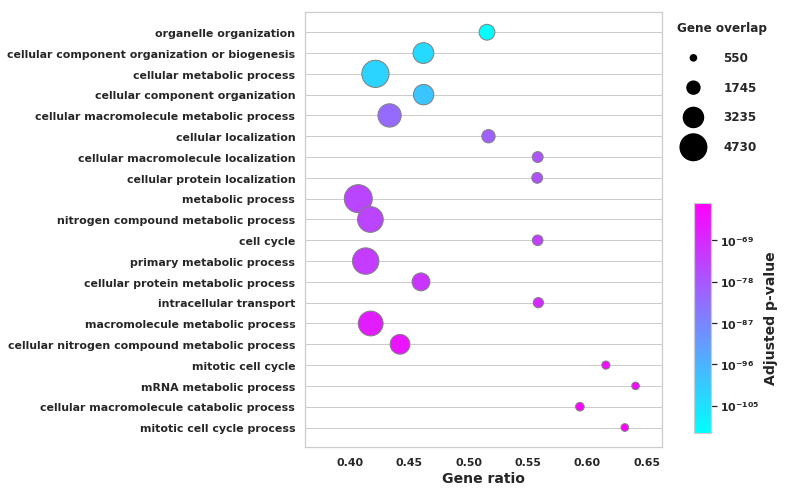

Cluster: NSC2


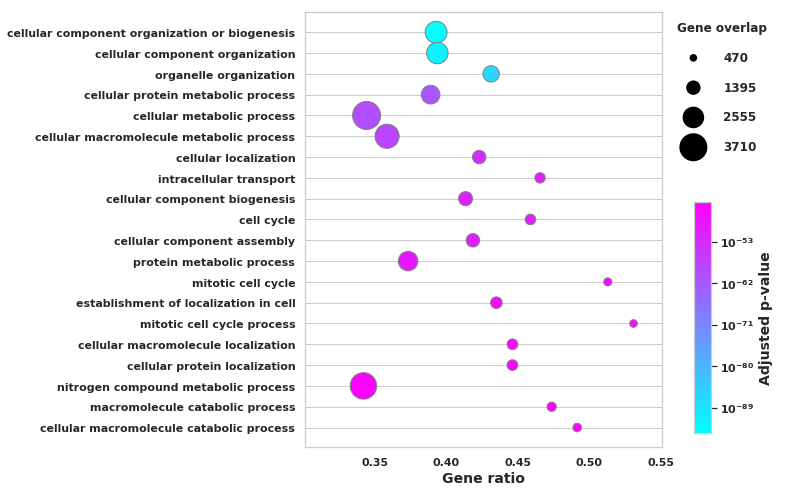

In [22]:
for clust in de_gobp_enrich_coarse:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_gobp_enrich_coarse[clust].columns) > 0:
        plot_enrich(de_gobp_enrich_coarse[clust])

Cluster: Glial prec. (myelinating)


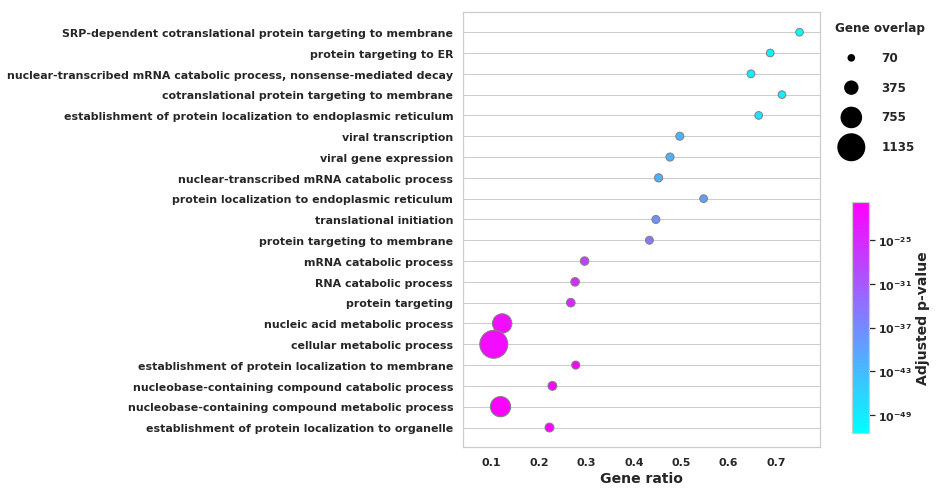

Cluster: NCSC


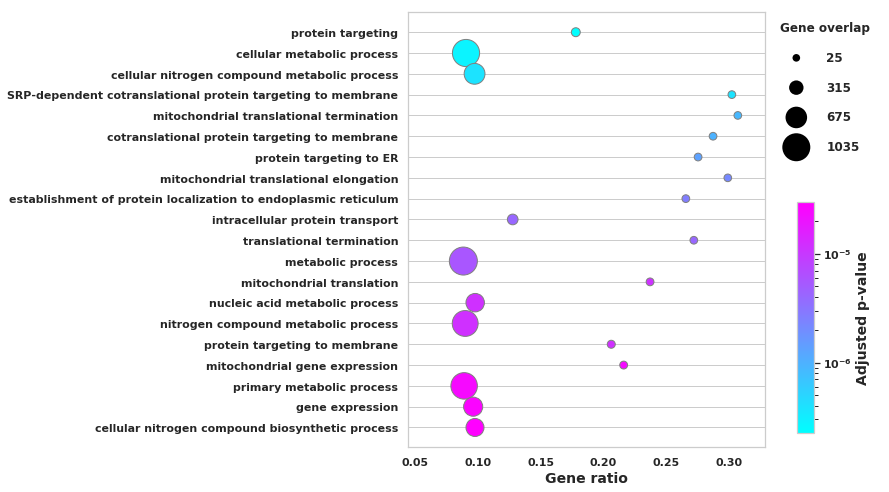

Cluster: Apop. NCSC


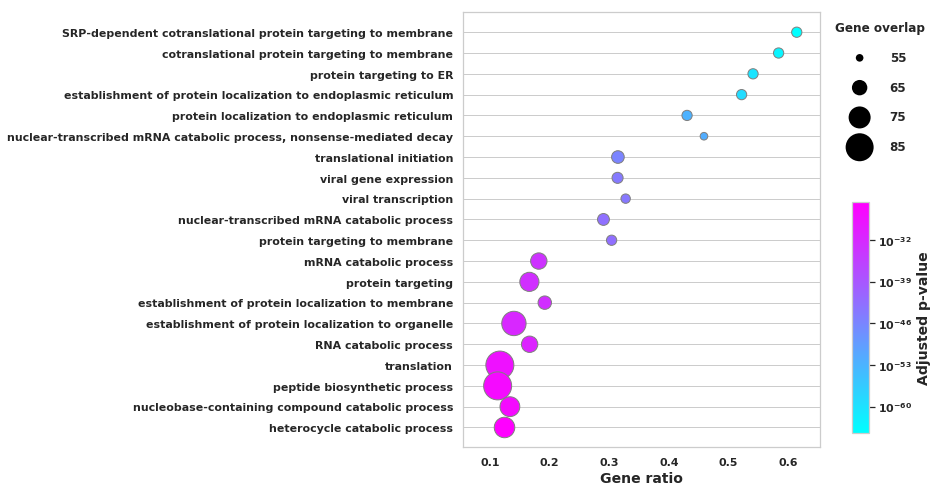

Cluster: NSC2


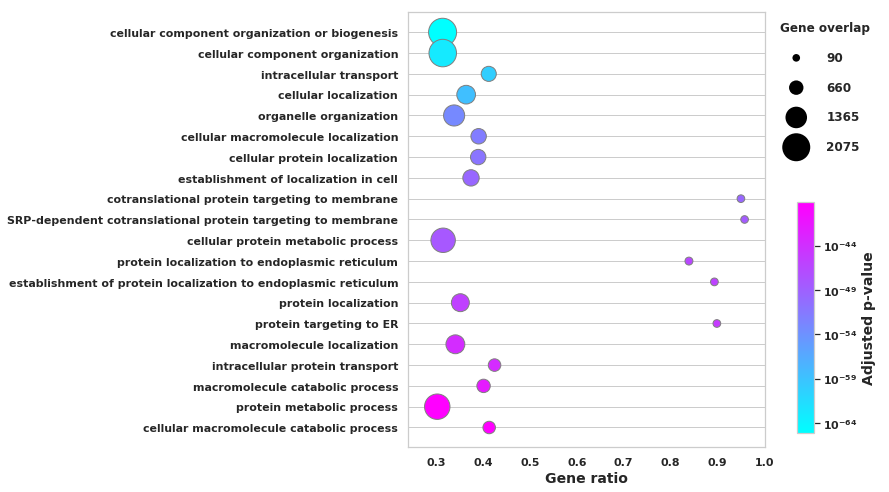

Cluster: NSC2 (G2M)


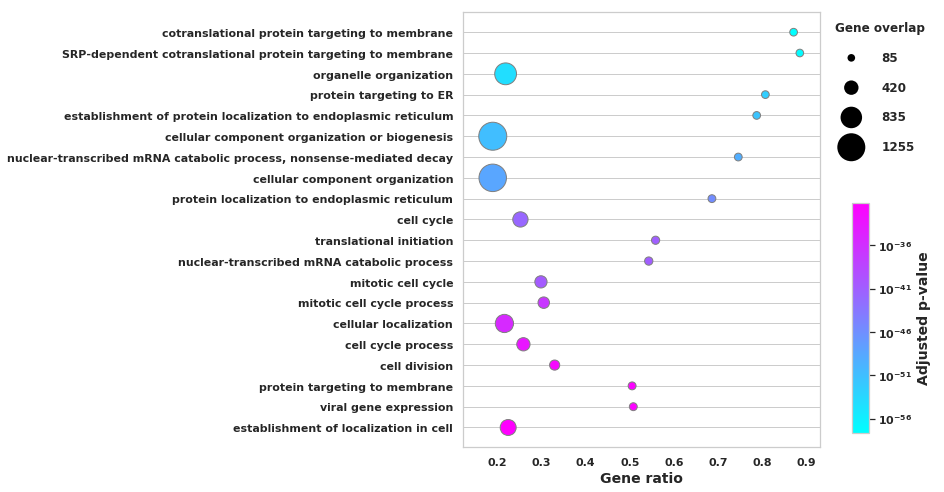

Cluster: NSC1


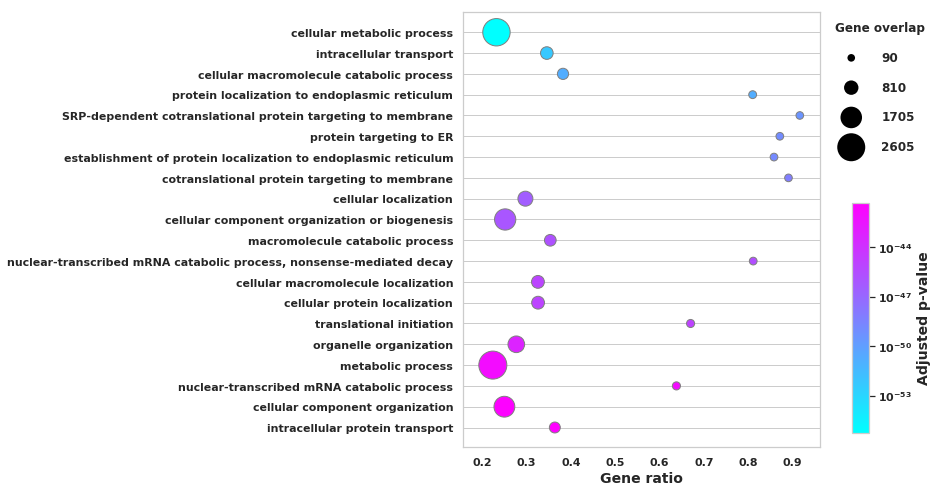

Cluster: NSC1 (G2M)


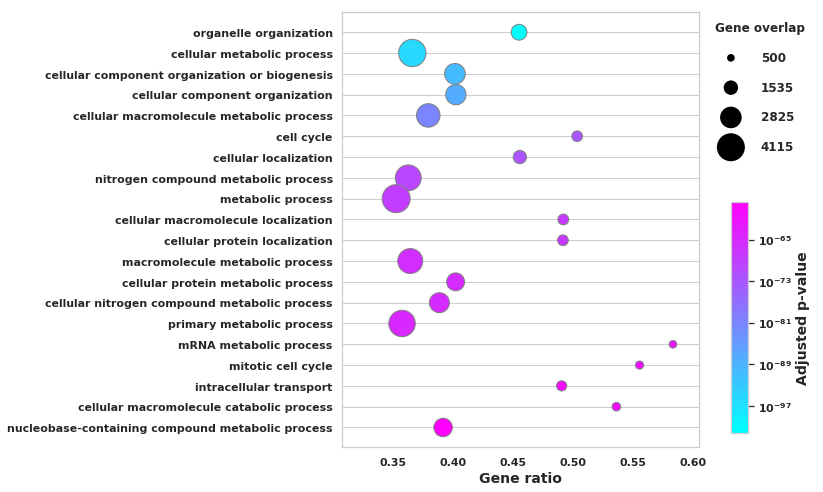

Cluster: immature neurons


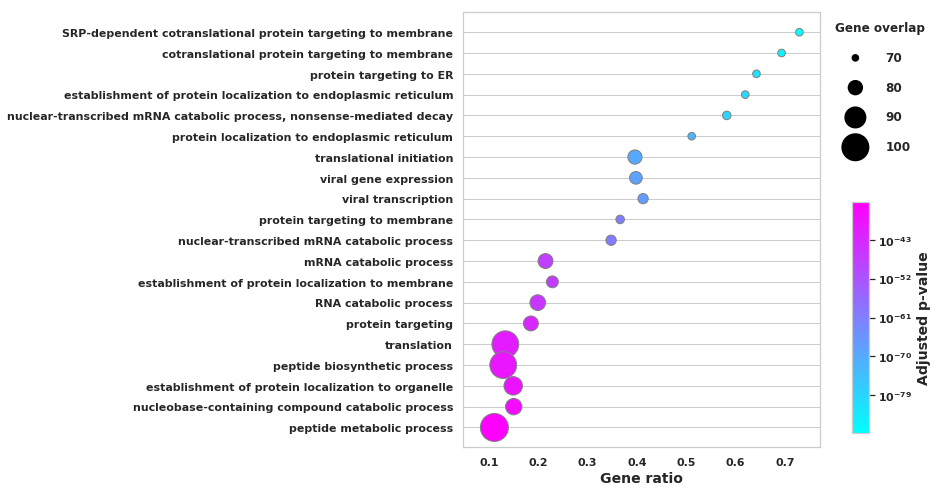

Cluster: Apop. NSC


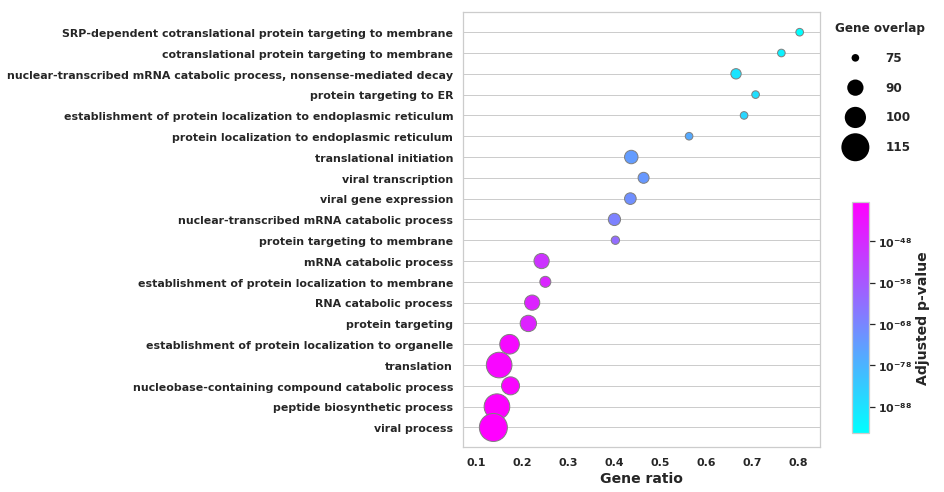

In [31]:
for clust in de_gobp_enrich:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_gobp_enrich[clust].columns) > 0:
        plot_enrich(de_gobp_enrich[clust])

Bulk-like:


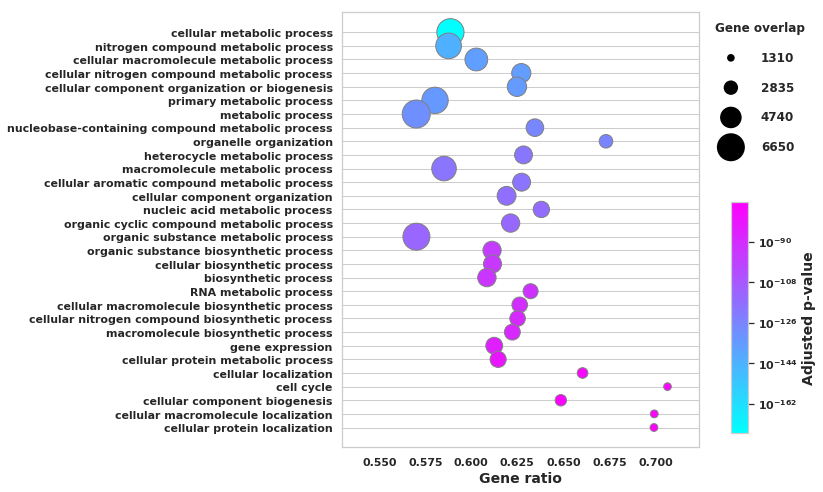

In [32]:
print('Bulk-like:')
if len(bulk_enrich.columns) > 0:
    plot_enrich(bulk_enrich, n_terms=30)

### KEGG Pathway enrichment

In [23]:
de_pathway_enrich_coarse = dict()

for clust in de_signif_coarse:
    tmp = gp.profile(organism='hsapiens', sources=['KEGG', 'REAC'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif_coarse[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_pathway_enrich_coarse[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_pathway_enrich_coarse[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_pathway_enrich_coarse[clust].iloc[:50,:]

Cluster NSC1:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-72766    2.276356e-39        292                228  0.780822   
REAC:R-HSA-8953854  6.424976e-39        663                428  0.645551   
REAC:R-HSA-1640170  1.483928e-38        632                411  0.650316   
REAC:R-HSA-168254   8.818403e-35        152                135  0.888158   
REAC:R-HSA-72613    7.573366e-34        120                112  0.933333   
REAC:R-HSA-72706    7.573366e-34        113                107  0.946903   
REAC:R-HSA-72737    7.573366e-34        120                112  0.933333   
REAC:R-HSA-69278    1.168756e-33        527                346  0.656546   
REAC:R-HSA-156827   1.313301e-33        112                106  0.946429   
REAC:R-HSA-5663205  1.767096e-33        370                262  0.708108   
REAC:R-HSA-392499   9.022310e-33       2014               1037  0.514896   
REAC:R-HSA-168255   9.929917e-33        142                126  0.887324   
KEGG:03010          2.860874e-30        134                117  0.873134   
REAC:R-HSA-72689    6.716005e-30        102                 96  0.941176   
REAC:R-HSA-168273   1.459496e-29        133                117  0.879699   
REAC:R-HSA-1799339  5.084578e-29        113                103  0.911504   
REAC:R-HSA-68877    8.470610e-29        195                155  0.794872   
REAC:R-HSA-2408557  2.570944e-28         94                 89  0.946809   
REAC:R-HSA-192823   2.970980e-28         90                 86  0.955556   
REAC:R-HSA-156902   2.970980e-28         90                 86  0.955556   
REAC:R-HSA-3700989  5.189009e-28        361                247  0.684211   
REAC:R-HSA-975957   5.651837e-28        116                104  0.896552   
REAC:R-HSA-927802   5.651837e-28        116                104  0.896552   
REAC:R-HSA-376176   1.894181e-27        217                166  0.764977   
REAC:R-HSA-72764    4.117534e-27         94                 88  0.936170   
REAC:R-HSA-156842   4.117534e-27         94                 88  0.936170   
REAC:R-HSA-975956   2.448578e-25         96                 88  0.916667   
REAC:R-HSA-2555396  7.950942e-25        196                150  0.765306   
REAC:R-HSA-9010553  1.178931e-24        171                135  0.789474   
REAC:R-HSA-68882    1.469251e-24        195                149  0.764103   
REAC:R-HSA-69618    3.875693e-24        108                 95  0.879630   
REAC:R-HSA-199991   5.879319e-24        626                372  0.594249   
REAC:R-HSA-68886    8.463308e-24        385                251  0.651948   
REAC:R-HSA-72203    5.002467e-23        238                171  0.718487   
REAC:R-HSA-2408522  2.216267e-22        117                 99  0.846154   
REAC:R-HSA-2467813  2.676551e-22        187                141  0.754011   
REAC:R-HSA-72172    2.676551e-22        187                141  0.754011   
REAC:R-HSA-72163    4.759172e-22        179                136  0.759777   
REAC:R-HSA-141424   9.833999e-22         92                 82  0.891304   
REAC:R-HSA-141444   9.833999e-22         92                 82  0.891304   
REAC:R-HSA-69620    4.758100e-21        289                195  0.674740   
REAC:R-HSA-422475   2.592239e-20        550                325  0.590909   
REAC:R-HSA-2500257  4.683515e-20        123                100  0.813008   
KEGG:05012          6.901738e-20        142                110  0.774648   
KEGG:00190          1.748859e-19        133                104  0.781955   
KEGG:05016          3.552017e-19        191                136  0.712042   
REAC:R-HSA-5663220  1.249582e-18        136                106  0.779412   
REAC:R-HSA-72662    2.165248e-18         60                 57  0.950000   
REAC:R-HSA-72649    5.047188e-18         59                 56  0.949153   
REAC:R-HSA-72702    5.047188e-18         59                 56  0.949153   

                                                                 name  


Cluster NSC2:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-72706    1.755147e-37        113                104  0.920354   
REAC:R-HSA-156827   2.541711e-37        112                103  0.919643   
REAC:R-HSA-72737    4.553084e-36        120                107  0.891667   
REAC:R-HSA-72613    4.553084e-36        120                107  0.891667   
REAC:R-HSA-1799339  1.589296e-35        113                102  0.902655   
REAC:R-HSA-156842   3.519653e-35         94                 89  0.946809   
REAC:R-HSA-192823   5.541556e-35         90                 86  0.955556   
REAC:R-HSA-156902   5.541556e-35         90                 86  0.955556   
REAC:R-HSA-72689    9.873092e-35        102                 94  0.921569   
REAC:R-HSA-72764    1.818819e-32         94                 87  0.925532   
REAC:R-HSA-975956   4.676108e-32         96                 88  0.916667   
REAC:R-HSA-927802   2.728348e-31        116                100  0.862069   
REAC:R-HSA-975957   2.728348e-31        116                100  0.862069   
REAC:R-HSA-2408557  3.035099e-31         94                 86  0.914894   
REAC:R-HSA-422475   6.360879e-31        550                311  0.565455   
REAC:R-HSA-72766    8.241589e-31        292                193  0.660959   
REAC:R-HSA-168254   2.309194e-30        152                120  0.789474   
REAC:R-HSA-168255   4.517831e-30        142                114  0.802817   
REAC:R-HSA-376176   1.130898e-27        217                151  0.695853   
REAC:R-HSA-168273   1.962217e-27        133                106  0.796992   
REAC:R-HSA-392499   5.435477e-26       2014                863  0.428500   
REAC:R-HSA-5663205  1.279823e-25        370                220  0.594595   
KEGG:03010          1.626986e-24        134                102  0.761194   
REAC:R-HSA-2408522  7.179805e-24        117                 93  0.794872   
REAC:R-HSA-9010553  7.422855e-24        171                122  0.713450   
REAC:R-HSA-1640170  8.478606e-21        632                320  0.506329   
REAC:R-HSA-69278    9.536736e-20        527                274  0.519924   
REAC:R-HSA-8953854  1.313971e-19        663                329  0.496229   
REAC:R-HSA-68877    2.613551e-19        195                127  0.651282   
REAC:R-HSA-199991   6.331125e-19        626                312  0.498403   
REAC:R-HSA-72662    9.492026e-19         60                 54  0.900000   
REAC:R-HSA-72702    2.497060e-18         59                 53  0.898305   
REAC:R-HSA-72649    2.497060e-18         59                 53  0.898305   
KEGG:00190          4.164185e-18        133                 93  0.699248   
KEGG:05016          2.687244e-17        191                119  0.623037   
KEGG:05012          2.687244e-17        142                 96  0.676056   
REAC:R-HSA-163200   1.419813e-16        123                 87  0.707317   
REAC:R-HSA-72695    1.810271e-16         52                 47  0.903846   
REAC:R-HSA-3700989  3.332442e-16        361                195  0.540166   
REAC:R-HSA-194315   1.538830e-15        449                230  0.512249   
KEGG:05010          3.417179e-15        171                106  0.619883   
REAC:R-HSA-611105   4.148661e-15        100                 73  0.730000   
REAC:R-HSA-68886    5.144449e-15        385                202  0.524675   
REAC:R-HSA-195258   9.136810e-14        319                171  0.536050   
REAC:R-HSA-2500257  2.630100e-13        123                 82  0.666667   
REAC:R-HSA-2555396  3.453327e-13        196                116  0.591837   
REAC:R-HSA-6791226  3.761674e-13        183                110  0.601093   
REAC:R-HSA-5663220  3.785233e-13        136                 88  0.647059   
REAC:R-HSA-68882    5.989151e-13        195                115  0.589744   
REAC:R-HSA-8868773  6.539847e-13        193                114  0.590674   

                                                                 name  


In [33]:
de_pathway_enrich = dict()

for clust in de_signif:
    tmp = gp.profile(organism='hsapiens', sources=['KEGG', 'REAC'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_pathway_enrich[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_pathway_enrich[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_pathway_enrich[clust].iloc[:50,:]

Cluster Glial prec. (myelinating):


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-156902   1.192603e-56         90                 73  0.811111   
REAC:R-HSA-156842   5.723050e-56         94                 74  0.787234   
REAC:R-HSA-2408557  1.415790e-54         94                 73  0.776596   
REAC:R-HSA-192823   5.067022e-54         90                 71  0.788889   
REAC:R-HSA-72764    2.470695e-53         94                 72  0.765957   
REAC:R-HSA-72689    2.470695e-53        102                 75  0.735294   
REAC:R-HSA-156827   1.153592e-52        112                 78  0.696429   
REAC:R-HSA-975956   2.559032e-52         96                 72  0.750000   
REAC:R-HSA-72706    6.063250e-51        113                 77  0.681416   
REAC:R-HSA-72737    1.286984e-50        120                 79  0.658333   
REAC:R-HSA-72613    1.286984e-50        120                 79  0.658333   
REAC:R-HSA-927802   1.807872e-48        116                 76  0.655172   
REAC:R-HSA-975957   1.807872e-48        116                 76  0.655172   
REAC:R-HSA-168273   1.020660e-45        133                 79  0.593985   
REAC:R-HSA-1799339  1.239393e-44        113                 72  0.637168   
REAC:R-HSA-2408522  2.370483e-44        117                 73  0.623932   
REAC:R-HSA-168255   5.917598e-44        142                 80  0.563380   
REAC:R-HSA-168254   7.764875e-43        153                 82  0.535948   
REAC:R-HSA-6791226  3.922889e-38        183                 85  0.464481   
KEGG:03010          2.887362e-37        134                 71  0.529851   
REAC:R-HSA-8868773  7.292615e-37        193                 86  0.445596   
REAC:R-HSA-72312    1.317222e-36        203                 88  0.433498   
REAC:R-HSA-9010553  2.618046e-33        171                 77  0.450292   
REAC:R-HSA-376176   6.794762e-29        217                 82  0.377880   
REAC:R-HSA-8953854  2.312345e-28        664                157  0.236446   
REAC:R-HSA-72766    1.364182e-25        292                 92  0.315068   
REAC:R-HSA-5663205  1.029817e-22        370                101  0.272973   
REAC:R-HSA-72649    5.666873e-20         59                 35  0.593220   
REAC:R-HSA-72662    1.196694e-19         60                 35  0.583333   
REAC:R-HSA-71291    3.739784e-19        365                 94  0.257534   
REAC:R-HSA-72695    5.844075e-19         52                 32  0.615385   
REAC:R-HSA-72702    6.998053e-19         59                 34  0.576271   
REAC:R-HSA-422475   4.458288e-12        550                106  0.192727   
REAC:R-HSA-1643685  3.096329e-10       1043                162  0.155321   
REAC:R-HSA-392499   2.340183e-06       2013                252  0.125186   
REAC:R-HSA-1430728  7.574281e-06       2069                255  0.123248   
REAC:R-HSA-74160    2.172318e-05       1455                188  0.129210   
REAC:R-HSA-429914   2.858908e-04         56                 17  0.303571   
REAC:R-HSA-429947   1.521254e-03         25                 10  0.400000   
KEGG:05168          1.563302e-03        486                 72  0.148148   
REAC:R-HSA-68877    1.666564e-03        195                 36  0.184615   
REAC:R-HSA-749476   1.829054e-03         41                 13  0.317073   
REAC:R-HSA-74158    1.829054e-03         41                 13  0.317073   
REAC:R-HSA-72306    1.863191e-03        103                 23  0.223301   
REAC:R-HSA-76046    1.941393e-03         36                 12  0.333333   
REAC:R-HSA-76071    4.070389e-03         28                 10  0.357143   
REAC:R-HSA-73857    5.071340e-03       1321                160  0.121120   
REAC:R-HSA-212436   5.412304e-03       1199                147  0.122602   
REAC:R-HSA-380320   9.925008e-03         94                 20  0.212766   
REAC:R-HSA-3247509  1.124843e-02        273                 43  0.157509   

                                                                 name  


Cluster NCSC:


p_value  term_size  intersection_size    recall  \
native                                                                     
KEGG:03010          4.029625e-14        134                 44  0.328358   
REAC:R-HSA-72766    6.819431e-14        292                 70  0.239726   
KEGG:05168          3.248298e-12        486                 90  0.185185   
REAC:R-HSA-5368286  3.768333e-07         87                 27  0.310345   
REAC:R-HSA-5419276  7.255512e-07         87                 26  0.298851   
REAC:R-HSA-5389840  7.255512e-07         87                 26  0.298851   
REAC:R-HSA-156827   7.255512e-07        112                 30  0.267857   
REAC:R-HSA-5368287  7.255512e-07         93                 27  0.290323   
REAC:R-HSA-975956   1.085094e-06         96                 27  0.281250   
REAC:R-HSA-156902   1.085094e-06         90                 26  0.288889   
REAC:R-HSA-2408522  1.475832e-06        117                 30  0.256410   
REAC:R-HSA-72706    1.669019e-06        113                 29  0.256637   
REAC:R-HSA-2408557  1.669019e-06         94                 26  0.276596   
REAC:R-HSA-1799339  1.669019e-06        113                 29  0.256637   
REAC:R-HSA-72737    1.669019e-06        120                 30  0.250000   
REAC:R-HSA-156842   1.669019e-06         94                 26  0.276596   
REAC:R-HSA-72613    1.669019e-06        120                 30  0.250000   
REAC:R-HSA-192823   2.539282e-06         90                 25  0.277778   
REAC:R-HSA-72764    6.147313e-06         94                 25  0.265957   
REAC:R-HSA-72689    8.135542e-06        102                 26  0.254902   
REAC:R-HSA-927802   8.360494e-06        116                 28  0.241379   
REAC:R-HSA-975957   8.360494e-06        116                 28  0.241379   
REAC:R-HSA-72312    2.172444e-05        203                 39  0.192118   
REAC:R-HSA-168273   4.594435e-05        133                 29  0.218045   
REAC:R-HSA-168255   5.782629e-05        142                 30  0.211268   
REAC:R-HSA-8868773  1.117342e-04        193                 36  0.186528   
REAC:R-HSA-6791226  2.258445e-04        183                 34  0.185792   
REAC:R-HSA-168254   2.593760e-04        153                 30  0.196078   
REAC:R-HSA-9010553  3.418722e-04        171                 32  0.187135   
REAC:R-HSA-392499   4.876456e-04       2013                213  0.105812   
REAC:R-HSA-8953854  1.205984e-03        664                 84  0.126506   
REAC:R-HSA-72649    2.518858e-03         59                 15  0.254237   
REAC:R-HSA-72662    3.009166e-03         60                 15  0.250000   
REAC:R-HSA-212436   3.749846e-03       1199                133  0.110926   
REAC:R-HSA-71291    3.834270e-03        365                 51  0.139726   
REAC:R-HSA-376176   6.368774e-03        217                 34  0.156682   
REAC:R-HSA-72702    8.441544e-03         59                 14  0.237288   
REAC:R-HSA-1852241  1.634734e-02        293                 41  0.139932   
REAC:R-HSA-5663205  3.063077e-02        370                 48  0.129730   
REAC:R-HSA-73857    3.307351e-02       1321                138  0.104466   

                                                                 name  
native                                                                 
KEGG:03010                                                   Ribosome  
REAC:R-HSA-72766                                          Translation  
KEGG:05168                           Herpes simplex virus 1 infection  
REAC:R-HSA-5368286               Mitochondrial translation initiation  
REAC:R-HSA-5419276              Mitochondrial translation termination  
REAC:R-HSA-5389840               Mitochondrial translation elongation  
REAC:R-HSA-156827   L13a-mediated translational silencing of Cerul...  
REAC:R-HSA-5368287                          Mitochondrial translation  
REAC:R-HSA-975956   Nonsense Mediated Decay (NMD) independent of t...  
REAC:R-HSA-156902                       

Cluster Apop. NCSC:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-156902   4.684054e-60         90                 56  0.622222   
REAC:R-HSA-1799339  5.475188e-59        113                 60  0.530973   
REAC:R-HSA-156842   5.823353e-59         94                 56  0.595745   
REAC:R-HSA-192823   7.083286e-59         90                 55  0.611111   
REAC:R-HSA-975956   1.940810e-58         96                 56  0.583333   
REAC:R-HSA-156827   3.638937e-58        112                 59  0.526786   
REAC:R-HSA-72689    3.638937e-58        102                 57  0.558824   
REAC:R-HSA-72764    1.053359e-57         94                 55  0.585106   
REAC:R-HSA-2408557  1.053359e-57         94                 55  0.585106   
REAC:R-HSA-72706    1.907881e-56        113                 58  0.513274   
REAC:R-HSA-72737    4.434651e-56        120                 59  0.491667   
REAC:R-HSA-72613    4.434651e-56        120                 59  0.491667   
REAC:R-HSA-927802   1.393782e-52        116                 56  0.482759   
REAC:R-HSA-975957   1.393782e-52        116                 56  0.482759   
REAC:R-HSA-2408522  8.284874e-51        117                 55  0.470085   
REAC:R-HSA-168273   1.981401e-48        133                 56  0.421053   
REAC:R-HSA-168255   6.420614e-48        142                 57  0.401408   
KEGG:03010          9.254014e-47        134                 56  0.417910   
REAC:R-HSA-72312    2.433774e-46        203                 64  0.315271   
REAC:R-HSA-168254   9.166223e-46        153                 57  0.372549   
REAC:R-HSA-9010553  3.470666e-45        171                 59  0.345029   
REAC:R-HSA-6791226  1.690714e-44        183                 60  0.327869   
REAC:R-HSA-8868773  3.302121e-44        193                 61  0.316062   
REAC:R-HSA-72766    4.246032e-42        292                 70  0.239726   
REAC:R-HSA-376176   7.820577e-41        217                 61  0.281106   
REAC:R-HSA-5663205  5.454214e-33        370                 68  0.183784   
REAC:R-HSA-8953854  1.827662e-30        664                 86  0.129518   
REAC:R-HSA-71291    8.770880e-29        365                 63  0.172603   
REAC:R-HSA-72649    3.623686e-27         59                 29  0.491525   
REAC:R-HSA-72662    6.587379e-27         60                 29  0.483333   
REAC:R-HSA-72695    3.917531e-26         52                 27  0.519231   
REAC:R-HSA-72702    1.054131e-25         59                 28  0.474576   
REAC:R-HSA-422475   1.150765e-21        550                 67  0.121818   
REAC:R-HSA-392499   8.137573e-15       2013                124  0.061600   
REAC:R-HSA-1643685  3.586863e-13       1043                 79  0.075743   
REAC:R-HSA-1266738  9.855732e-12       1065                 77  0.072300   
REAC:R-HSA-1430728  3.288152e-08       2069                109  0.052682   
REAC:R-HSA-5696394  3.477128e-03         38                  7  0.184211   
REAC:R-HSA-6783310  4.018696e-03         39                  7  0.179487   
REAC:R-HSA-6790901  1.107640e-02         60                  8  0.133333   
REAC:R-HSA-5205685  1.107640e-02         22                  5  0.227273   
REAC:R-HSA-209543   1.137612e-02         13                  4  0.307692   
REAC:R-HSA-209560   1.137612e-02         13                  4  0.307692   
REAC:R-HSA-5689901  1.852867e-02         37                  6  0.162162   
REAC:R-HSA-1253288  1.981248e-02          7                  3  0.428571   
REAC:R-HSA-205043   2.457411e-02         16                  4  0.250000   
REAC:R-HSA-193639   2.457411e-02         16                  4  0.250000   
REAC:R-HSA-5205647  2.489518e-02         27                  5  0.185185   
REAC:R-HSA-73894    2.596617e-02        330                 21  0.063636   
REAC:R-HSA-162909   3.056494e-02        125                 11  0.088000   

                                                                 name  


Cluster NSC2:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-72706    7.015420e-47        113                104  0.920354   
REAC:R-HSA-156827   1.264367e-46        112                103  0.919643   
REAC:R-HSA-1799339  7.116272e-46        113                103  0.911504   
REAC:R-HSA-72737    1.066823e-45        120                107  0.891667   
REAC:R-HSA-72613    1.066823e-45        120                107  0.891667   
REAC:R-HSA-72689    4.823948e-43        102                 94  0.921569   
REAC:R-HSA-156902   7.301375e-43         90                 86  0.955556   
REAC:R-HSA-192823   7.301375e-43         90                 86  0.955556   
REAC:R-HSA-156842   7.578526e-42         94                 88  0.936170   
REAC:R-HSA-72764    2.496462e-40         94                 87  0.925532   
REAC:R-HSA-72766    4.957910e-40        292                186  0.636986   
REAC:R-HSA-975956   5.158928e-40         96                 88  0.916667   
REAC:R-HSA-2408557  1.689660e-37         94                 85  0.904255   
REAC:R-HSA-975957   4.089156e-33        116                 94  0.810345   
REAC:R-HSA-927802   4.089156e-33        116                 94  0.810345   
REAC:R-HSA-168255   1.325278e-32        142                107  0.753521   
REAC:R-HSA-168254   3.361290e-32        153                112  0.732026   
KEGG:03010          5.364712e-32        134                102  0.761194   
REAC:R-HSA-376176   1.405332e-31        217                141  0.649770   
REAC:R-HSA-168273   2.416060e-30        133                100  0.751880   
REAC:R-HSA-422475   3.564405e-30        550                270  0.490909   
REAC:R-HSA-2408522  1.413055e-29        117                 91  0.777778   
REAC:R-HSA-392499   1.342844e-28       2013                737  0.366120   
REAC:R-HSA-9010553  1.685227e-28        171                116  0.678363   
REAC:R-HSA-5663205  5.538848e-28        370                198  0.535135   
KEGG:00190          9.827167e-24        133                 92  0.691729   
REAC:R-HSA-72662    1.805633e-23         60                 54  0.900000   
REAC:R-HSA-163200   3.002683e-23        123                 87  0.707317   
REAC:R-HSA-72649    5.608833e-23         59                 53  0.898305   
REAC:R-HSA-72702    5.608833e-23         59                 53  0.898305   
KEGG:05012          1.800868e-21        142                 93  0.654930   
REAC:R-HSA-72695    1.389480e-20         52                 47  0.903846   
REAC:R-HSA-199991   3.281595e-20        626                272  0.434505   
KEGG:05016          8.178790e-19        192                110  0.572917   
KEGG:05010          1.213203e-18        171                101  0.590643   
REAC:R-HSA-1428517  3.568554e-18        173                102  0.589595   
REAC:R-HSA-611105   1.856256e-17        100                 69  0.690000   
KEGG:04141          6.508147e-16        165                 94  0.569697   
REAC:R-HSA-6791226  8.381551e-16        183                102  0.557377   
REAC:R-HSA-8868773  8.381551e-16        193                106  0.549223   
REAC:R-HSA-8953854  1.102063e-15        664                271  0.408133   
KEGG:04714          1.205064e-15        231                119  0.515152   
REAC:R-HSA-72312    2.664195e-14        203                107  0.527094   
REAC:R-HSA-5653656  6.942876e-14        720                283  0.393056   
REAC:R-HSA-3700989  7.007545e-13        361                161  0.445983   
REAC:R-HSA-5628897  2.765134e-11         83                 53  0.638554   
REAC:R-HSA-1643685  1.129012e-10       1043                370  0.354746   
KEGG:04932          1.276126e-10        149                 78  0.523490   
REAC:R-HSA-6811442  2.946899e-09        203                 96  0.472906   
REAC:R-HSA-1266738  4.000555e-09       1065                369  0.346479   

                                                                 name  


Cluster NSC2 (G2M):


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-156827   1.656027e-66        112                100  0.892857   
REAC:R-HSA-72706    2.695148e-64        113                 99  0.876106   
REAC:R-HSA-156902   8.161618e-64         90                 86  0.955556   
REAC:R-HSA-156842   2.910149e-63         94                 88  0.936170   
REAC:R-HSA-72689    1.348631e-62        102                 92  0.901961   
REAC:R-HSA-72613    1.538234e-62        120                101  0.841667   
REAC:R-HSA-72737    1.538234e-62        120                101  0.841667   
REAC:R-HSA-192823   3.181278e-62         90                 85  0.944444   
REAC:R-HSA-72764    6.467509e-60         94                 86  0.914894   
REAC:R-HSA-1799339  9.075568e-59        113                 95  0.840708   
REAC:R-HSA-2408557  3.054666e-58         94                 85  0.904255   
REAC:R-HSA-975956   3.630744e-58         96                 86  0.895833   
REAC:R-HSA-975957   2.671247e-51        116                 91  0.784483   
REAC:R-HSA-927802   2.671247e-51        116                 91  0.784483   
KEGG:03010          4.349174e-47        134                 95  0.708955   
REAC:R-HSA-2408522  2.126605e-44        117                 86  0.735043   
REAC:R-HSA-168254   2.442753e-44        153                100  0.653595   
REAC:R-HSA-168255   1.996991e-43        142                 95  0.669014   
REAC:R-HSA-168273   1.211242e-40        133                 89  0.669173   
REAC:R-HSA-72766    1.934132e-39        292                139  0.476027   
REAC:R-HSA-9010553  2.770973e-36        171                 98  0.573099   
REAC:R-HSA-376176   6.065415e-35        217                111  0.511521   
REAC:R-HSA-72662    9.461251e-32         60                 51  0.850000   
REAC:R-HSA-72649    5.302608e-31         59                 50  0.847458   
REAC:R-HSA-422475   1.590798e-30        550                190  0.345455   
REAC:R-HSA-72702    1.441471e-29         59                 49  0.830508   
REAC:R-HSA-72695    1.048203e-28         52                 45  0.865385   
REAC:R-HSA-1640170  7.272761e-28        632                203  0.321203   
REAC:R-HSA-68877    5.945799e-27        195                 94  0.482051   
REAC:R-HSA-6791226  1.304632e-26        183                 90  0.491803   
REAC:R-HSA-69278    1.051203e-25        527                175  0.332068   
REAC:R-HSA-5663205  1.370882e-25        370                138  0.372973   
REAC:R-HSA-8868773  3.209767e-25        193                 91  0.471503   
REAC:R-HSA-72312    3.137853e-23        203                 91  0.448276   
REAC:R-HSA-68886    1.430426e-18        385                128  0.332468   
REAC:R-HSA-195258   1.045902e-16        319                109  0.341693   
REAC:R-HSA-392499   1.705689e-16       2013                429  0.213115   
REAC:R-HSA-2500257  5.931391e-16        123                 58  0.471545   
KEGG:00190          8.858927e-16        133                 61  0.458647   
REAC:R-HSA-163200   1.514853e-14        123                 56  0.455285   
REAC:R-HSA-5663220  3.745857e-14        136                 59  0.433824   
REAC:R-HSA-69275    7.759927e-14        196                 74  0.377551   
KEGG:05012          1.316171e-13        142                 60  0.422535   
REAC:R-HSA-8953854  1.352504e-13        664                174  0.262048   
REAC:R-HSA-453274   1.391042e-13        198                 74  0.373737   
REAC:R-HSA-194315   4.535837e-13        449                129  0.287305   
KEGG:04110          5.789545e-13        124                 54  0.435484   
REAC:R-HSA-1266738  8.789445e-13       1065                247  0.231925   
REAC:R-HSA-71291    1.331182e-12        365                110  0.301370   
REAC:R-HSA-2565942  1.898275e-12         85                 42  0.494118   

                                                                 name  


Cluster NSC1:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-72766    9.558063e-57        292                193  0.660959   
REAC:R-HSA-72613    2.609512e-56        120                109  0.908333   
REAC:R-HSA-72737    2.609512e-56        120                109  0.908333   
REAC:R-HSA-72706    3.649181e-55        113                104  0.920354   
REAC:R-HSA-156827   1.257203e-54        112                103  0.919643   
REAC:R-HSA-72689    1.287051e-51        102                 95  0.931373   
REAC:R-HSA-1799339  2.475391e-49        113                100  0.884956   
REAC:R-HSA-192823   2.512569e-49         90                 86  0.955556   
REAC:R-HSA-156902   2.512569e-49         90                 86  0.955556   
REAC:R-HSA-156842   1.876313e-48         94                 88  0.936170   
REAC:R-HSA-2408557  1.876313e-48         94                 88  0.936170   
REAC:R-HSA-72764    7.925793e-47         94                 87  0.925532   
KEGG:03010          8.277788e-47        134                109  0.813433   
REAC:R-HSA-975956   1.603971e-46         96                 88  0.916667   
REAC:R-HSA-975957   2.126192e-43        116                 97  0.836207   
REAC:R-HSA-927802   2.126192e-43        116                 97  0.836207   
REAC:R-HSA-9010553  2.126166e-42        171                123  0.719298   
REAC:R-HSA-168255   5.409731e-41        142                108  0.760563   
REAC:R-HSA-2408522  2.221858e-40        117                 95  0.811966   
REAC:R-HSA-168254   8.409850e-40        153                112  0.732026   
REAC:R-HSA-376176   5.874265e-39        217                139  0.640553   
REAC:R-HSA-168273   2.986027e-38        133                101  0.759398   
REAC:R-HSA-5663205  2.745468e-37        370                195  0.527027   
REAC:R-HSA-8953854  7.807937e-36        664                290  0.436747   
KEGG:00190          1.605702e-30        133                 93  0.699248   
REAC:R-HSA-392499   6.649992e-30       2013                648  0.321908   
REAC:R-HSA-72662    2.136583e-27         60                 54  0.900000   
REAC:R-HSA-163200   3.845647e-27        123                 85  0.691057   
REAC:R-HSA-72649    7.900246e-27         59                 53  0.898305   
REAC:R-HSA-72702    7.900246e-27         59                 53  0.898305   
KEGG:05012          9.847874e-25        142                 90  0.633803   
REAC:R-HSA-71291    1.045503e-24        365                171  0.468493   
REAC:R-HSA-1428517  3.063440e-24        173                102  0.589595   
REAC:R-HSA-72695    4.932743e-24         52                 47  0.903846   
REAC:R-HSA-6791226  1.167364e-23        183                105  0.573770   
REAC:R-HSA-8868773  3.896695e-23        193                108  0.559585   
REAC:R-HSA-72312    4.959606e-22        203                110  0.541872   
REAC:R-HSA-422475   1.713506e-21        550                222  0.403636   
REAC:R-HSA-611105   3.152817e-20        100                 67  0.670000   
KEGG:05016          3.651236e-19        192                101  0.526042   
KEGG:05010          5.303146e-19        171                 93  0.543860   
KEGG:04714          3.015363e-16        231                109  0.471861   
REAC:R-HSA-1430728  1.755607e-14       2069                598  0.289029   
REAC:R-HSA-72172    1.632192e-13        188                 90  0.478723   
REAC:R-HSA-6799198  6.325694e-13         55                 39  0.709091   
KEGG:04932          6.335540e-13        149                 75  0.503356   
REAC:R-HSA-72163    2.444964e-12        180                 85  0.472222   
REAC:R-HSA-72203    3.125430e-12        239                104  0.435146   
REAC:R-HSA-199991   6.923908e-12        626                216  0.345048   
KEGG:04141          1.291845e-10        165                 76  0.460606   

                                                                 name  


Cluster NSC1 (G2M):


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-1640170  2.559190e-40        632                382  0.604430   
REAC:R-HSA-72613    5.972833e-40        120                112  0.933333   
REAC:R-HSA-72737    5.972833e-40        120                112  0.933333   
REAC:R-HSA-72706    7.040681e-40        113                107  0.946903   
REAC:R-HSA-156827   1.585007e-39        112                106  0.946429   
REAC:R-HSA-72766    8.523399e-38        292                210  0.719178   
REAC:R-HSA-168254   2.477773e-36        153                130  0.849673   
REAC:R-HSA-69278    3.950202e-36        527                323  0.612903   
KEGG:03010          1.462503e-35        134                116  0.865672   
REAC:R-HSA-72689    2.636294e-35        102                 96  0.941176   
REAC:R-HSA-168255   3.394979e-35        142                122  0.859155   
REAC:R-HSA-5663205  9.981875e-34        370                243  0.656757   
REAC:R-HSA-8953854  3.502464e-33        664                379  0.570783   
REAC:R-HSA-156902   3.785511e-33         90                 86  0.955556   
REAC:R-HSA-192823   3.785511e-33         90                 86  0.955556   
REAC:R-HSA-168273   8.945342e-33        133                114  0.857143   
REAC:R-HSA-975957   1.642546e-32        116                103  0.887931   
REAC:R-HSA-927802   1.642546e-32        116                103  0.887931   
REAC:R-HSA-1799339  1.842214e-32        113                101  0.893805   
REAC:R-HSA-2408557  4.273107e-32         94                 88  0.936170   
REAC:R-HSA-156842   4.273107e-32         94                 88  0.936170   
REAC:R-HSA-975956   1.339898e-31         96                 89  0.927083   
REAC:R-HSA-392499   1.379815e-30       2013                921  0.457526   
REAC:R-HSA-72764    1.976968e-29         94                 86  0.914894   
REAC:R-HSA-376176   6.382485e-29        217                157  0.723502   
REAC:R-HSA-68877    8.364693e-29        195                145  0.743590   
REAC:R-HSA-9010553  1.339832e-26        171                129  0.754386   
REAC:R-HSA-3700989  4.880941e-26        361                224  0.620499   
REAC:R-HSA-2408522  1.116418e-24        117                 96  0.820513   
KEGG:05016          3.520053e-24        192                135  0.703125   
KEGG:05012          4.180744e-23        142                107  0.753521   
REAC:R-HSA-422475   6.132990e-23        550                303  0.550909   
REAC:R-HSA-68886    1.515297e-22        385                228  0.592208   
KEGG:00190          2.445952e-22        133                101  0.759398   
REAC:R-HSA-72662    1.478952e-21         60                 57  0.950000   
REAC:R-HSA-2555396  1.478952e-21        196                135  0.688776   
REAC:R-HSA-69618    2.614595e-21        108                 87  0.805556   
REAC:R-HSA-68882    2.854813e-21        195                134  0.687179   
REAC:R-HSA-72203    3.072624e-21        239                156  0.652720   
REAC:R-HSA-72702    3.509853e-21         59                 56  0.949153   
REAC:R-HSA-72649    3.509853e-21         59                 56  0.949153   
REAC:R-HSA-141424   6.755912e-21         92                 77  0.836957   
REAC:R-HSA-2500257  6.755912e-21        123                 95  0.772358   
REAC:R-HSA-141444   6.755912e-21         92                 77  0.836957   
REAC:R-HSA-72163    1.620212e-20        180                125  0.694444   
REAC:R-HSA-69620    3.555275e-20        289                178  0.615917   
REAC:R-HSA-2467813  3.694778e-20        187                128  0.684492   
REAC:R-HSA-163200   3.902566e-20        123                 94  0.764228   
REAC:R-HSA-72172    7.373105e-20        188                128  0.680851   
REAC:R-HSA-199991   1.523502e-19        626                326  0.520767   

                                                                 name  


Cluster immature neurons:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-156902   3.620240e-92         90                 71  0.788889   
REAC:R-HSA-156842   5.708564e-90         94                 71  0.755319   
REAC:R-HSA-192823   2.770540e-88         90                 69  0.766667   
REAC:R-HSA-72689    6.467839e-88        102                 72  0.705882   
REAC:R-HSA-156827   4.037440e-87        112                 74  0.660714   
REAC:R-HSA-72706    9.538623e-87        113                 74  0.654867   
REAC:R-HSA-2408557  2.291896e-86         94                 69  0.734043   
REAC:R-HSA-72764    2.291896e-86         94                 69  0.734043   
REAC:R-HSA-975956   2.531777e-85         96                 69  0.718750   
REAC:R-HSA-72737    4.965020e-84        120                 74  0.616667   
REAC:R-HSA-72613    4.965020e-84        120                 74  0.616667   
REAC:R-HSA-1799339  1.719337e-79        113                 70  0.619469   
REAC:R-HSA-975957   1.503638e-76        116                 69  0.594828   
REAC:R-HSA-927802   1.503638e-76        116                 69  0.594828   
REAC:R-HSA-2408522  3.345558e-76        117                 69  0.589744   
REAC:R-HSA-168273   3.393656e-74        133                 71  0.533835   
REAC:R-HSA-168255   1.755683e-71        142                 71  0.500000   
KEGG:03010          2.126155e-71        134                 71  0.529851   
REAC:R-HSA-168254   1.731443e-68        153                 71  0.464052   
REAC:R-HSA-9010553  1.068584e-62        171                 70  0.409357   
REAC:R-HSA-6791226  3.203924e-60        183                 70  0.382514   
REAC:R-HSA-8868773  1.005285e-59        193                 71  0.367876   
REAC:R-HSA-376176   3.134751e-58        217                 73  0.336406   
REAC:R-HSA-72312    6.158190e-58        203                 71  0.349754   
REAC:R-HSA-72766    2.728445e-56        292                 80  0.273973   
REAC:R-HSA-5663205  1.864056e-45        370                 78  0.210811   
REAC:R-HSA-71291    1.338389e-39        365                 72  0.197260   
REAC:R-HSA-422475   1.040250e-38        550                 85  0.154545   
REAC:R-HSA-72695    1.925889e-35         52                 32  0.615385   
REAC:R-HSA-72702    1.247871e-34         59                 33  0.559322   
REAC:R-HSA-72649    1.247871e-34         59                 33  0.559322   
REAC:R-HSA-72662    2.616902e-34         60                 33  0.550000   
REAC:R-HSA-8953854  3.411835e-33        664                 86  0.129518   
REAC:R-HSA-1266738  4.510818e-22       1065                 92  0.086385   
REAC:R-HSA-1643685  2.901496e-20       1043                 88  0.084372   
REAC:R-HSA-392499   1.761558e-15       2013                119  0.059116   
REAC:R-HSA-1430728  1.494306e-14       2069                119  0.057516   
REAC:R-HSA-8876725  2.147653e-03         17                  5  0.294118   
REAC:R-HSA-9013507  1.487765e-02         25                  5  0.200000   
REAC:R-HSA-2691232  1.565925e-02         15                  4  0.266667   
REAC:R-HSA-74160    1.565925e-02       1455                 62  0.042612   
REAC:R-HSA-2691230  1.565925e-02         15                  4  0.266667   
REAC:R-HSA-1253288  1.630993e-02          7                  3  0.428571   
REAC:R-HSA-69231    2.723220e-02         43                  6  0.139535   
REAC:R-HSA-69236    2.723220e-02         43                  6  0.139535   
REAC:R-HSA-73857    2.990547e-02       1321                 56  0.042392   
REAC:R-HSA-6790901  3.078770e-02         60                  7  0.116667   
REAC:R-HSA-77595    3.470028e-02         19                  4  0.210526   
REAC:R-HSA-168927   3.470028e-02         19                  4  0.210526   
REAC:R-HSA-177539   4.416548e-02          3                  2  0.666667   

                                                                 name  


Cluster Apop. NSC:


p_value  term_size  intersection_size    recall  \
native                                                                      
REAC:R-HSA-156902   2.899396e-101         90                 79  0.877778   
REAC:R-HSA-156842   1.635811e-100         94                 80  0.851064   
REAC:R-HSA-192823    4.117259e-97         90                 77  0.855556   
REAC:R-HSA-975956    4.549089e-97         96                 79  0.822917   
REAC:R-HSA-2408557   2.342528e-94         94                 77  0.819149   
REAC:R-HSA-72764     2.342528e-94         94                 77  0.819149   
REAC:R-HSA-72689     3.141925e-91        102                 78  0.764706   
REAC:R-HSA-156827    1.448668e-89        112                 80  0.714286   
REAC:R-HSA-975957    1.252180e-87        116                 80  0.689655   
REAC:R-HSA-927802    1.252180e-87        116                 80  0.689655   
REAC:R-HSA-72706     2.714602e-87        113                 79  0.699115   
REAC:R-HSA-72737     7.695261e-86        120                 80  0.666667   
REAC:R-HSA-72613     7.695261e-86        120                 80  0.666667   
REAC:R-HSA-1799339   1.580307e-85        113                 78  0.690265   
REAC:R-HSA-2408522   1.180809e-83        117                 78  0.666667   
REAC:R-HSA-168255    7.927391e-79        142                 81  0.570423   
REAC:R-HSA-168273    8.288932e-79        133                 79  0.593985   
REAC:R-HSA-168254    3.144672e-75        153                 81  0.529412   
KEGG:03010           4.772860e-71        134                 77  0.574627   
REAC:R-HSA-9010553   4.466697e-70        171                 81  0.473684   
REAC:R-HSA-6791226   2.917720e-64        183                 79  0.431694   
REAC:R-HSA-8868773   4.727470e-62        193                 79  0.409326   
REAC:R-HSA-376176    3.555738e-61        217                 82  0.377880   
REAC:R-HSA-72312     5.134996e-60        203                 79  0.389163   
REAC:R-HSA-72766     3.351767e-56        292                 88  0.301370   
REAC:R-HSA-5663205   5.409342e-54        370                 95  0.256757   
REAC:R-HSA-71291     3.067659e-47        365                 88  0.241096   
REAC:R-HSA-422475    5.239797e-44        550                102  0.185455   
REAC:R-HSA-72695     5.489395e-37         52                 35  0.673077   
REAC:R-HSA-72649     9.565953e-36         59                 36  0.610169   
REAC:R-HSA-72662     2.236622e-35         60                 36  0.600000   
REAC:R-HSA-8953854   8.616948e-35        664                100  0.150602   
REAC:R-HSA-72702     3.755133e-34         59                 35  0.593220   
REAC:R-HSA-1643685   3.674399e-28       1043                116  0.111218   
REAC:R-HSA-1266738   2.069760e-21       1065                106  0.099531   
REAC:R-HSA-392499    1.091114e-19       2013                152  0.075509   
REAC:R-HSA-1430728   2.136689e-19       2069                154  0.074432   
REAC:R-HSA-3371497   9.681623e-04         57                 10  0.175439   
REAC:R-HSA-380320    9.681623e-04         94                 13  0.138298   
REAC:R-HSA-69275     2.724876e-03        196                 19  0.096939   
REAC:R-HSA-453274    3.041321e-03        198                 19  0.095960   
REAC:R-HSA-389977    3.450238e-03         23                  6  0.260870   
REAC:R-HSA-380270    3.561875e-03         80                 11  0.137500   
REAC:R-HSA-380287    3.561875e-03         80                 11  0.137500   
REAC:R-HSA-389958    3.654390e-03         33                  7  0.212121   
REAC:R-HSA-2565942   5.883452e-03         85                 11  0.129412   
REAC:R-HSA-437239    7.011354e-03         48                  8  0.166667   
REAC:R-HSA-445355    8.630032e-03         38                  7  0.184211   
REAC:R-HSA-373760    8.645621e-03        119                 13  0.109244   
REAC:R-HSA-389957    9.039920e-03         28                  6  0.214286   

                     

In [34]:
#Bulk-like
bulk_enrich_pw = tmp = gp.profile(organism='hsapiens', sources=['KEGG', 'REAC'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=bulk_res_filt['gene'].tolist())
    
if bulk_enrich_pw is not None:
    bulk_enrich_pw.set_index('native', inplace=True)
    bulk_enrich_pw.sort_values('p_value').iloc[:,[2,5,7,10,1]]
else:
    bulk_enrich_pw = pd.DataFrame()
    
# Print some results
print('Bulk-like:')
bulk_enrich_pw.iloc[:50,:]

p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-8953854  6.404258e-63        664                561  0.844880   
REAC:R-HSA-72766    5.371706e-50        292                274  0.938356   
REAC:R-HSA-1640170  4.648147e-37        632                496  0.784810   
REAC:R-HSA-392499   5.496235e-37       2013               1348  0.669647   
REAC:R-HSA-74160    8.480534e-35       1455               1007  0.692096   
REAC:R-HSA-69278    1.676144e-32        527                417  0.791271   
KEGG:03010          3.683441e-29        134                130  0.970149   
REAC:R-HSA-72203    2.403102e-28        239                211  0.882845   
REAC:R-HSA-73857    9.369567e-28       1321                903  0.683573   
REAC:R-HSA-5663205  1.366238e-27        370                302  0.816216   
REAC:R-HSA-168254   1.752520e-27        153                145  0.947712   
REAC:R-HSA-3700989  1.402034e-26        361                294  0.814404   
REAC:R-HSA-168255   5.347372e-26        142                135  0.950704   
REAC:R-HSA-168273   5.490601e-25        133                127  0.954887   
REAC:R-HSA-72172    7.232606e-25        188                169  0.898936   
REAC:R-HSA-72737    2.391323e-24        120                116  0.966667   
REAC:R-HSA-72613    2.391323e-24        120                116  0.966667   
REAC:R-HSA-72163    5.114023e-24        180                162  0.900000   
REAC:R-HSA-1799339  5.232777e-24        113                110  0.973451   
REAC:R-HSA-72706    5.232777e-24        113                110  0.973451   
REAC:R-HSA-156827   9.050399e-24        112                109  0.973214   
REAC:R-HSA-68877    3.231760e-23        195                172  0.882051   
REAC:R-HSA-376176   1.500096e-22        217                187  0.861751   
REAC:R-HSA-72689    3.090913e-21        102                 99  0.970588   
REAC:R-HSA-927802   5.238300e-21        116                110  0.948276   
...                          ...        ...                ...       ...   
REAC:R-HSA-449836   4.340654e-02        271                165  0.608856   
REAC:R-HSA-195721   4.340654e-02        327                197  0.602446   
REAC:R-HSA-9009391  4.366314e-02         74                 50  0.675676   
KEGG:05135          4.735692e-02        121                 76  0.628099   
REAC:R-HSA-194840   4.794874e-02        140                 89  0.635714   
REAC:R-HSA-110357   4.874770e-02          7                  7  1.000000   
REAC:R-HSA-3304351  4.874770e-02          7                  7  1.000000   
REAC:R-HSA-1253288  4.874770e-02          7                  7  1.000000   
REAC:R-HSA-2980767  4.874770e-02          7                  7  1.000000   
REAC:R-HSA-3065678  4.874770e-02          7                  7  1.000000   
REAC:R-HSA-204998   4.901474e-02         76                 51  0.671053   
REAC:R-HSA-212165   4.925542e-02        147                 93  0.632653   
REAC:R-HSA-6811436  4.925542e-02         53                 37  0.698113   
REAC:R-HSA-69091    4.993577e-02         14                 12  0.857143   
REAC:R-HSA-8875360  4.993577e-02         14                 12  0.857143   
REAC:R-HSA-69109    4.993577e-02         14                 12  0.857143   
REAC:R-HSA-174495   4.993577e-02         14                 12  0.857143   
REAC:R-HSA-174411   4.993577e-02         14                 12  0.857143   
REAC:R-HSA-5358606  4.993577e-02         14                 12  0.857143   
REAC:R-HSA-5637812  4.993577e-02         14                 12  0.857143   
REAC:R-HSA-174490   4.993577e-02         14                 12  0.857143   
REAC:R-HSA-5637810  4.993577e-02         14                 12  0.857143   
REAC:R-HSA-5358565  4.993577e-02         14                 12  0.857143   
REAC:R-HSA-1295596  4.993577e-02         14                 12  0.857143   
REAC:R-HSA-177504   4.993577e-02         14                 12  0.857143 

Bulk-like:


source                                               name  \
native                                                                         
REAC:R-HSA-8953854   REAC                                  Metabolism of RNA   
REAC:R-HSA-72766     REAC                                        Translation   
REAC:R-HSA-1640170   REAC                                         Cell Cycle   
REAC:R-HSA-392499    REAC                             Metabolism of proteins   
REAC:R-HSA-74160     REAC                    Gene expression (Transcription)   
REAC:R-HSA-69278     REAC                                Cell Cycle, Mitotic   
KEGG:03010           KEGG                                           Ribosome   
REAC:R-HSA-72203     REAC    Processing of Capped Intron-Containing Pre-mRNA   
REAC:R-HSA-73857     REAC                    RNA Polymerase II Transcription   
REAC:R-HSA-5663205   REAC                                 Infectious disease   
REAC:R-HSA-168254    REAC                                Influenza Infection   
REAC:R-HSA-3700989   REAC                 Transcriptional Regulation by TP53   
REAC:R-HSA-168255    REAC                               Influenza Life Cycle   
REAC:R-HSA-168273    REAC  Influenza Viral RNA Transcription and Replication   
REAC:R-HSA-72172     REAC                                      mRNA Splicing   
REAC:R-HSA-72737     REAC               Cap-dependent Translation Initiation   
REAC:R-HSA-72613     REAC                  Eukaryotic Translation Initiation   
REAC:R-HSA-72163     REAC                      mRNA Splicing - Major Pathway   
REAC:R-HSA-1799339   REAC  SRP-dependent cotranslational protein targetin...   
REAC:R-HSA-72706     REAC  GTP hydrolysis and joining of the 60S ribosoma...   
REAC:R-HSA-156827    REAC  L13a-mediated translational silencing of Cerul...   
REAC:R-HSA-68877     REAC                               Mitotic Prometaphase   
REAC:R-HSA-376176    REAC                        Signaling by ROBO receptors   
REAC:R-HSA-72689     REAC           Formation of a pool of free 40S subunits   
REAC:R-HSA-927802    REAC                      Nonsense-Mediated Decay (NMD)   
REAC:R-HSA-975957    REAC  Nonsense Mediated Decay (NMD) enhanced by the ...   
REAC:R-HSA-163200    REAC  Respiratory electron transport, ATP synthesis ...   
REAC:R-HSA-212436    REAC                      Generic Transcription Pathway   
REAC:R-HSA-1428517   REAC  The citric acid (TCA) cycle and respiratory el...   
REAC:R-HSA-68886     REAC                                            M Phase   
REAC:R-HSA-6791226   REAC  Major pathway of rRNA processing in the nucleo...   
REAC:R-HSA-8868773   REAC         rRNA processing in the nucleus and cytosol   
REAC:R-HSA-72312     REAC                                    rRNA processing   
REAC:R-HSA-611105    REAC                     Respiratory electron transport   
REAC:R-HSA-2408557   REAC                           Selenocysteine synthesis   
REAC:R-HSA-199991    REAC                               Membrane Trafficking   
REAC:R-HSA-69618     REAC                         Mitotic Spindle Checkpoint   
REAC:R-HSA-2555396   REAC                     Mitotic Metaphase and Anaphase   
REAC:R-HSA-9010553   REAC        Regulation of expression of SLITs and ROBOs   
REAC:R-HSA-68882     REAC                                   Mitotic Anaphase   
REAC:R-HSA-141444    REAC  Amplification  of signal from unattached  kine...   
REAC:R-HSA-141424    REAC      Amplification of signal from the kinetochores   
REAC:R-HSA-975956    REAC  Nonsense Mediated Decay (NMD) independent of t...   
REAC:R-HSA-192823    REAC                             Viral mRNA Translation   
REAC:R-HSA-156902    REAC                           Peptide chain elongation   
REAC:R-HSA-2408522   REAC                        Selenoamino acid metabolism   
REAC:R-HSA-156842    REAC                  Eukaryotic Translation Elongation   
REAC:R-HSA-5368287   REAC                          Mitochondrial translation   
REAC:R-HSA-69620   

Cluster: NSC1


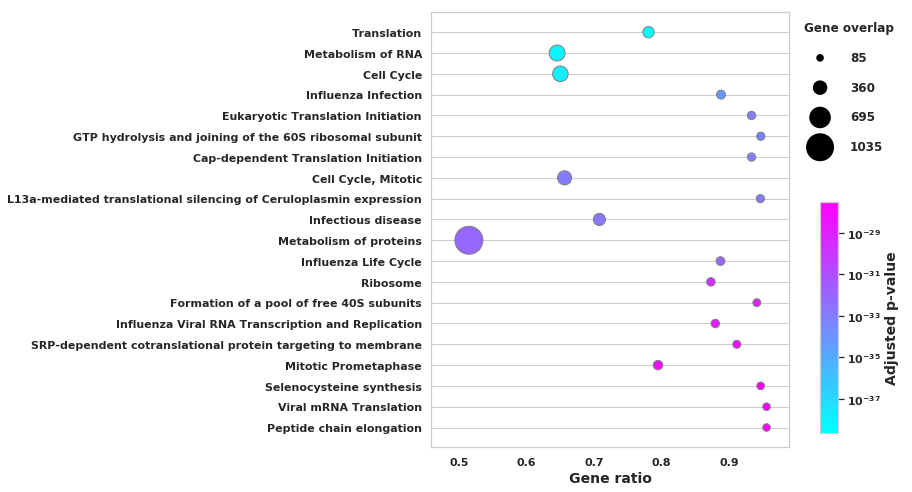

Cluster: NSC2


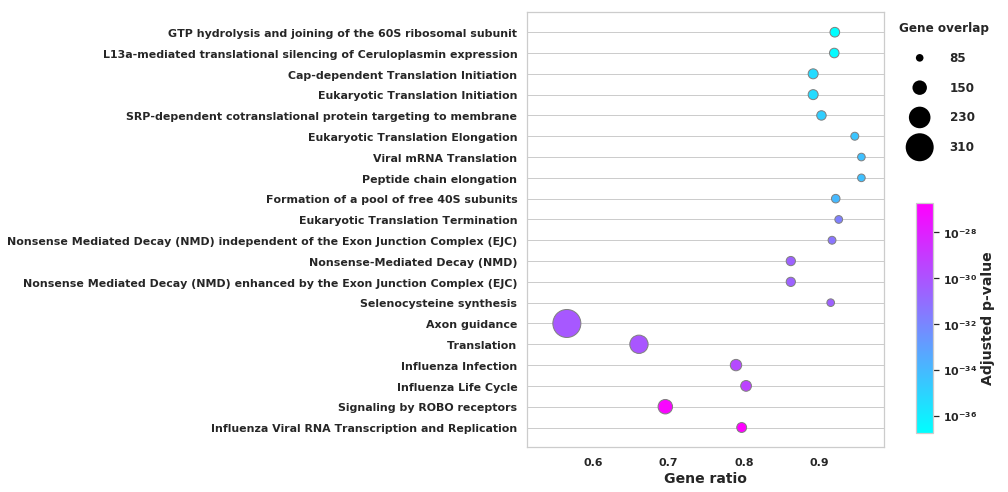

In [24]:
for clust in de_pathway_enrich_coarse:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_pathway_enrich_coarse[clust].columns) > 0:
        plot_enrich(de_pathway_enrich_coarse[clust])

Cluster: Glial prec. (myelinating)


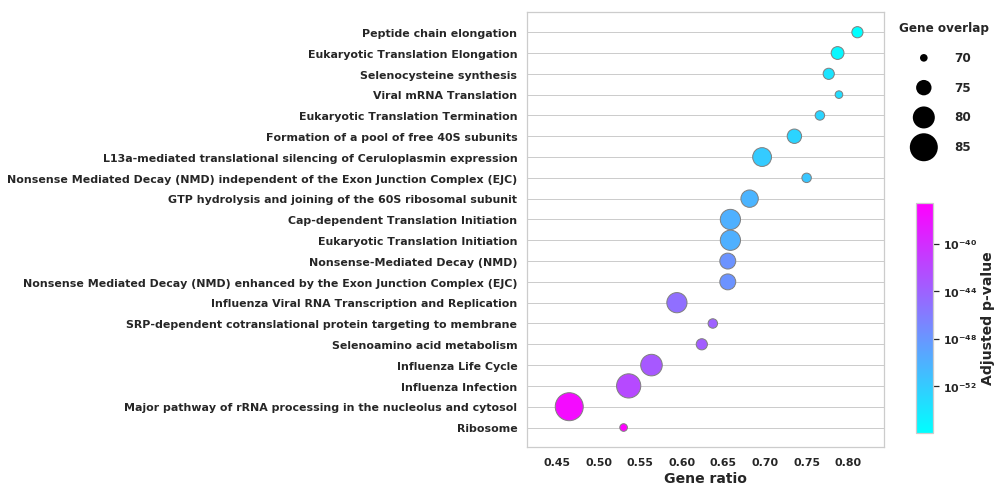

Cluster: NCSC


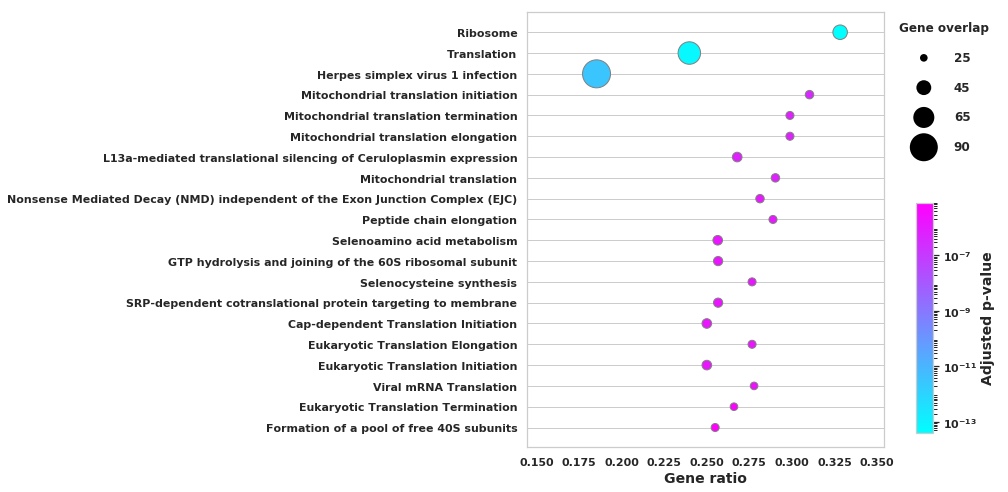

Cluster: Apop. NCSC


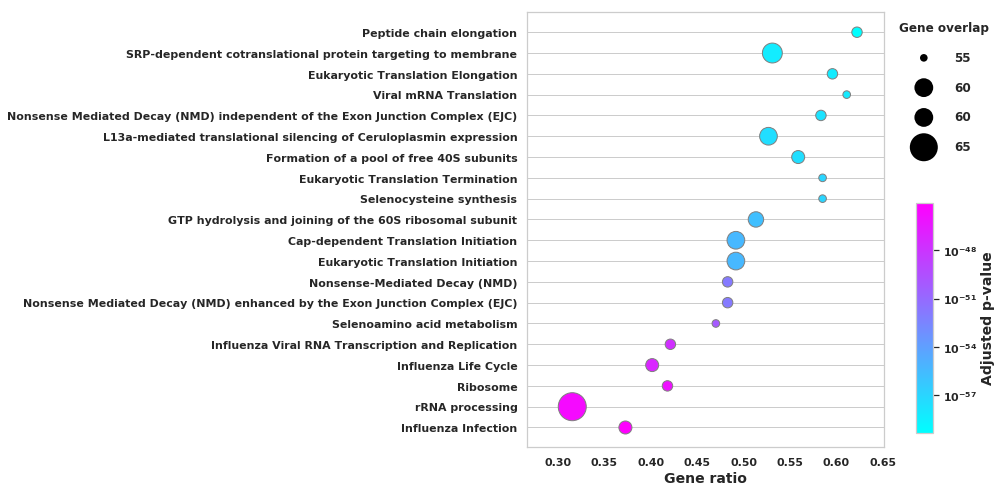

Cluster: NSC2


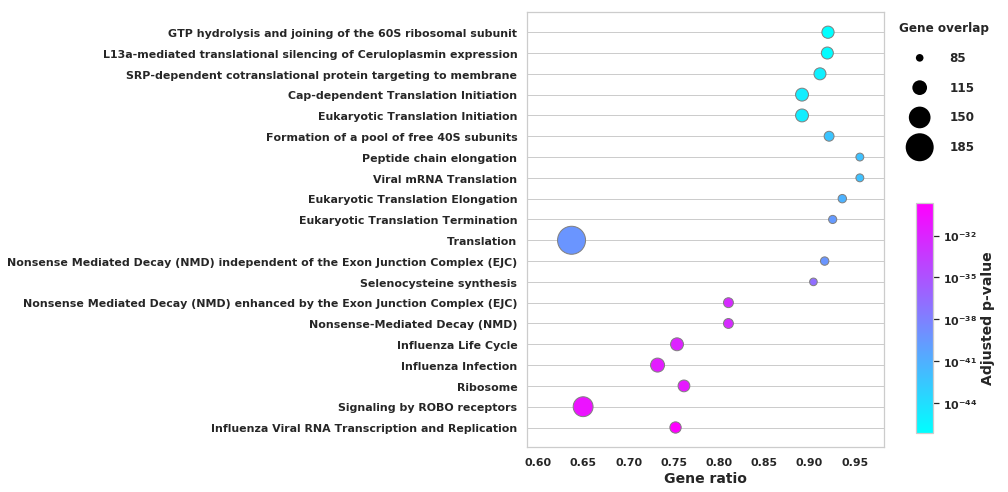

Cluster: NSC2 (G2M)


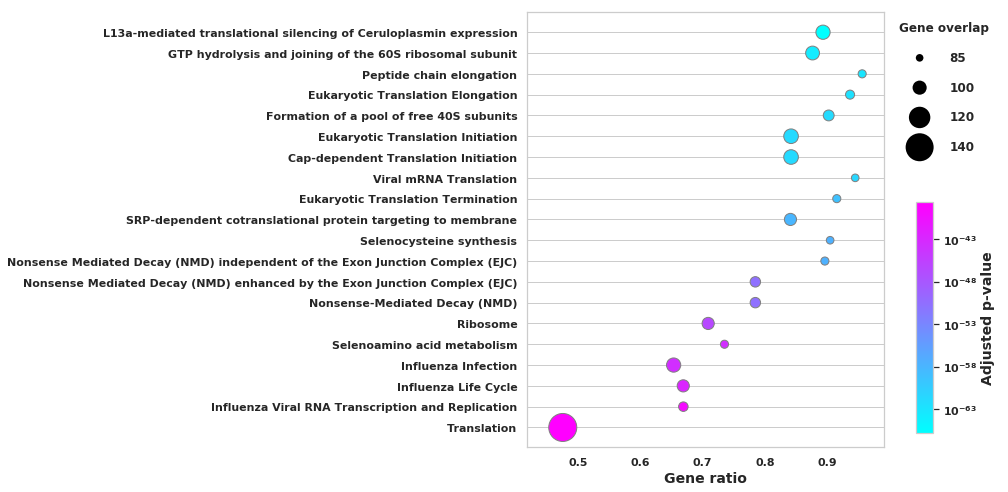

Cluster: NSC1


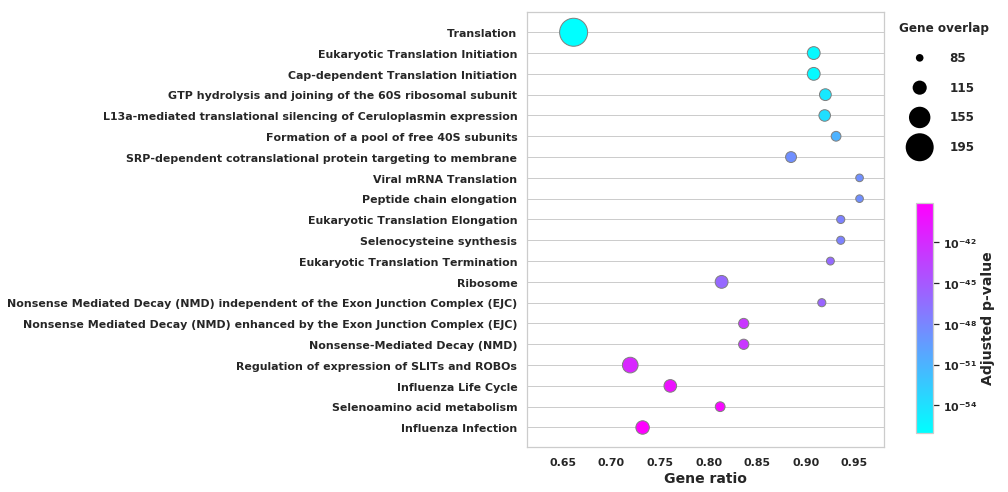

Cluster: NSC1 (G2M)


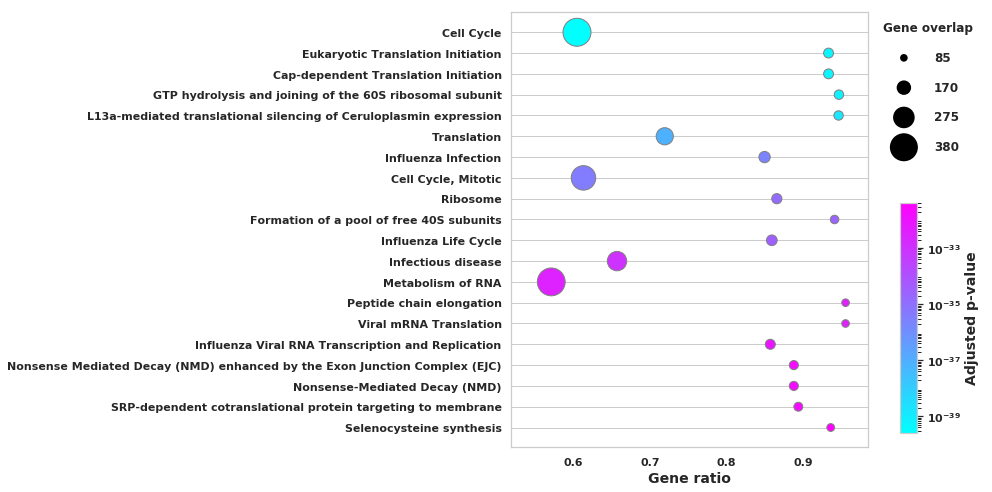

Cluster: immature neurons


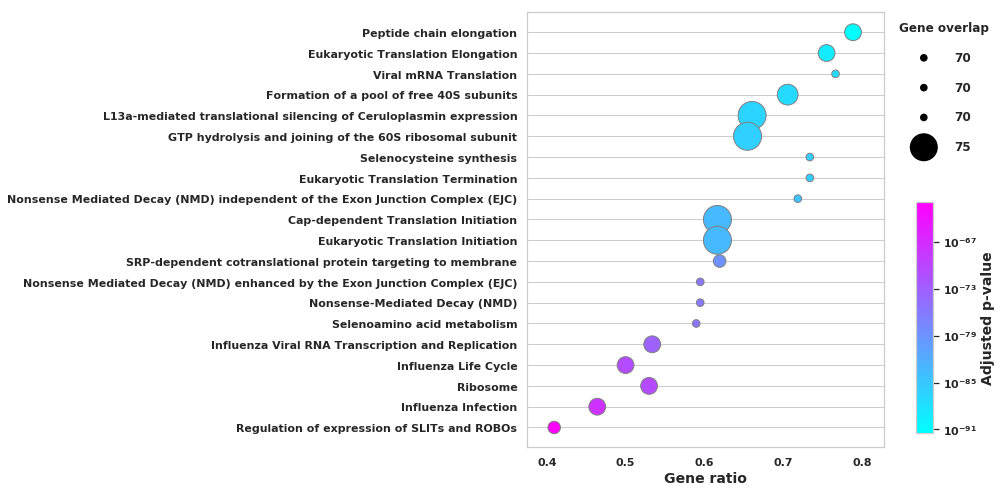

Cluster: Apop. NSC


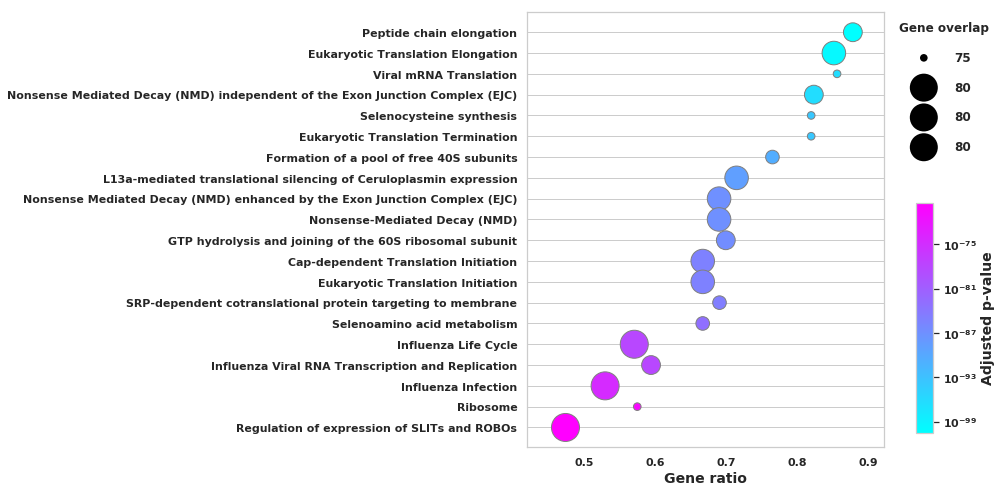

In [35]:
for clust in de_pathway_enrich:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_pathway_enrich[clust].columns) > 0:
        plot_enrich(de_pathway_enrich[clust])

Bulk-like:


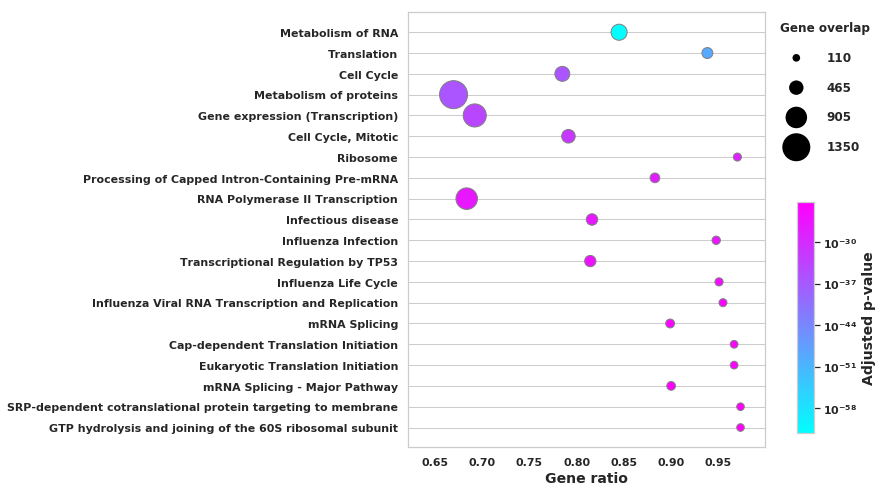

In [36]:
print('Bulk-like:')
if len(bulk_enrich_pw.columns) > 0:
    plot_enrich(bulk_enrich_pw)

# Check individual gene

### Foxa2

In [37]:
goi = 'FOXA2'

for clust in de_results:
    print(f'Cluster {clust}:')
    tmp2 = de_results[clust].summary()
    if goi in tmp2['gene'].values:
        tmp2.query('gene == "'+goi+'"')
    else:
        print(f'Gene {goi} was not tested for Cluster {clust}.')
        print('')

Cluster Glial prec. (myelinating):


gene      pval  qval    log2fc      mean  zero_mean      grad  \
18910  FOXA2  0.992482   1.0 -0.017602  0.014388      False  0.016852   

       coef_mle   coef_sd         ll  
18910 -0.017602  1.868122 -657.10437

Cluster NCSC:


gene      pval  qval   log2fc      mean  zero_mean      grad  \
20365  FOXA2  0.905138   1.0  0.30619  0.023543      False  0.011133   

       coef_mle   coef_sd          ll  
20365   0.30619  2.569281 -506.514345

Cluster Apop. NCSC:
Gene FOXA2 was not tested for Cluster Apop. NCSC.

Cluster NSC2:


gene      pval      qval    log2fc      mean  zero_mean      grad  \
20769  FOXA2  0.649956  0.916562 -0.013828  1.284072      False  0.006671   

       coef_mle   coef_sd           ll  
20769 -0.013828  0.030471 -8928.777504

Cluster NSC2 (G2M):


gene      pval  qval    log2fc      mean  zero_mean     grad  \
20525  FOXA2  0.752142   1.0  0.012666  2.535101      False  0.02164   

       coef_mle   coef_sd           ll  
20525  0.012666  0.040106 -3763.588844

Cluster NSC1:


gene      pval      qval    log2fc      mean  zero_mean      grad  \
20811  FOXA2  0.399232  0.794587 -0.119577  0.141547      False  0.027733   

       coef_mle   coef_sd           ll  
20811 -0.119577  0.141848 -2802.418003

Cluster NSC1 (G2M):


gene     pval      qval    log2fc      mean  zero_mean     grad  \
20883  FOXA2  0.13421  0.308428 -0.100803  0.477221      False  0.04186   

       coef_mle   coef_sd           ll  
20883 -0.100803  0.067305 -5395.757958

Cluster immature neurons:


gene      pval  qval    log2fc      mean  zero_mean      grad  \
18692  FOXA2  0.414139   1.0  0.506531  0.203008      False  0.090148   

       coef_mle   coef_sd         ll  
18692  0.506531  0.620269 -210.55376

Cluster Apop. NSC:


gene      pval  qval    log2fc     mean  zero_mean      grad  \
19369  FOXA2  0.130669   1.0 -0.584065  0.04611      False  0.031935   

       coef_mle   coef_sd          ll  
19369 -0.584065  0.386422 -246.743888

In [38]:
goi = 'FOXA2'

print('Bulk-like:')
tmp2 = test_bulk.summary()
if goi in tmp2['gene'].values:
    tmp2.query('gene == "'+goi+'"')
else:
    print(f'Gene {goi} was not tested for Cluster bulk-like.')
    print('')

Bulk-like:


gene      pval      qval    log2fc      mean  zero_mean      grad  \
22020  FOXA2  0.020476  0.042052  0.056346  0.562457      False  0.073976   

       coef_mle   coef_sd            ll  
22020  0.056346  0.024313 -27539.881101

Interesting that FOXA2 is up-regulated on the bulk-like analysis, but not in any individual cell cluster. Perhaps there is not sufficient power in any cluster to find it significantly up-regulated.

# Save data

In [25]:
import pickle

In [27]:
#Pickle the de output
pickle.dump(de_results_coarse, open(de_output_pickle_coarse, "wb"))

In [39]:
#Pickle the de output
pickle.dump(de_results, open(de_output_pickle, "wb"))

In [28]:
#Output individual results
for clust in de_signif_coarse:
    
    filename_signif = de_output_base+'_coarse_significant005_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    filename_full = de_output_base+'_coarse_full_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    
    de_signif_coarse[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_signif)
    de_full_res_coarse[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_full)

In [40]:
#Output individual results
for clust in de_signif:
    
    filename_signif = de_output_base+'_significant005_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    filename_full = de_output_base+'_full_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    
    de_signif[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_signif)
    de_full_res[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_full)

In [41]:
#Pick the DE output - Bulk-like
import pickle
pickle.dump(test_bulk, open(de_output_pickle_bulk, "wb"))

In [42]:
#Output individual results - Bulk-like

filename_signif = de_output_base+'_significant005_'+'bulk_like'+'.csv'
filename_full = de_output_base+'_full_'+'bulk_like'+'.csv'
    
bulk_res_filt.iloc[:,[0,2,3,4,8]].to_csv(filename_signif)
bulk_res.iloc[:,[0,2,3,4,8]].to_csv(filename_full)

# Output enrichment data

In [29]:
#Output enrichment results per cluster
for clust in de_gobp_enrich_coarse:
    fn_base = enrich_output_base+'_coarse_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')

    if de_gobp_enrich_coarse[clust].shape != (0,0):
        de_gobp_enrich_coarse[clust].to_csv(fn_base+'_gobp.csv')

    if de_pathway_enrich_coarse[clust].shape != (0,0):
        de_pathway_enrich_coarse[clust].to_csv(fn_base+'_pathway.csv')

In [43]:
#Output enrichment results per cluster
for clust in de_gobp_enrich:
    fn_base = enrich_output_base+'_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')

    if de_gobp_enrich[clust].shape != (0,0):
        de_gobp_enrich[clust].to_csv(fn_base+'_gobp.csv')

    if de_pathway_enrich[clust].shape != (0,0):
        de_pathway_enrich[clust].to_csv(fn_base+'_pathway.csv')

In [44]:
#Output enrichment results - bulk-like
    fn_base = enrich_output_base+'_'+'bulk_like'

    if bulk_enrich.shape != (0,0):
        bulk_enrich.to_csv(fn_base+'_gobp.csv')

    if bulk_enrich_pw.shape != (0,0):
        bulk_enrich_pw.to_csv(fn_base+'_pathway.csv')